## Job Change of Data Scientists after Training Program

------ Sourav Sinha, Department of Economics (PhD Candidate), Yale University
_______________________________________________________________________________________________________________________________
_______________________________________________________________________________________________________________________________

### Preview


![title](Images/ComparisonModels.png)


![title](Images/FeatureEffectsOnExistDecision.png)
 



### Executive Summary

#### (A) Project Goals:

1. Explain effects of employee and job characteristics on decision to leave job. 
2. Predict employee churn (exit) using labelled data on employee and job characteristics.  

#### (B) Data Analyses Methods:

1. Data Wrangling and Feature Correction:
    * Conversion of Data Types
    * Renaming levels of categorical features to improve interpretability. 
    * Deletion of redundant and irrelevant features. 
    * Using 3 different methods to impute missing values in both numeric and categorical features. 
        - (a) Simple Imputation (Mean/Median/Mode imputation)
        - (b) MissForest Imputation 
        - (c) MICEForest Imputation
2. Feature Contribution towards Exit Decisions:
    * Using Linear Probability Model and Logistic Regression model to estimate effects of features on decision to leave. 
    * Comparing feature contribution towards exit decisions across statistical models and imputated datasets. 
    * Interpeting and Explaining positive and negative effects of features on exit decisions.  
3. Predicting Exit using following Classifier Models:
    * Training following classifier models on labelled data to predict exit:
        (a) Logistic Regression 
        (b) Logistic Regression with Hyperparameter Tuning 
        (c) Logistic Regression with Recursive Feature Elimination 
        (d) Random Forest Classifier
        (e) Gradient Boosting Classifier 
        (f) Neural Networks implemented in Tensorflow
    * Generating different training sets using the following sampling techniques:
        (a) Unbalanced training set 
        (b) Oversampling of less-frequent class
        (c) Undersampling of more frequent class
4. Comparing test prediction metrics to find best imputation and sampling methods and classifier model.

#### (C) Conclusion:

1. 25% of data scientists leave after their training program is over in the full dataset. 
2. Having higher education and being full-time enrolled at university is more likely to induce exits. 
3. Having longer years of experience in the job market and relevant experience is more likely to induce employees to stay. 
4. If precision and roc-auc are objective test metrics, then apply a Gradient Boosting Classifier to the dataset built using simple imputation and keep the training set unbalanced. 
    * Best Model: 0.55 Precision, 0.66 ROC-AUC Score. 
5. If precision is the only objective test metric, then train a Logistic Regression classifier with Recursive Feature Elimination with Cross Validation on a dataset built using simple imputation and oversample the less frequent class in the training set. 
    * Best Model: 0.67 Precision
6. If ROC-Auc Score is the only objective metric, then train an XGBoost classifier on a simply imputed dataset and again oversample the less frequent class. 
    * Best Model: 0.73 ROC-AUC Score
7. If accuracy is the only objective metric, then train a Logistic Regression classifier with Recursive Feature Elimination with Cross Validation on a dataset built using simple imputation and undersample the more frequent class in the training set. 
    * Best Model: 0.77 Accuracy 
    
    
**END**

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend import Legend
import os
import csv
from csv import reader
import random
import math
import chardet
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import heapq
import re
import plotnine
import copy
import pydot
import graphviz
import datetime
import jinja2
import statistics
import itertools
from IPython.display import Image
from IPython.core.display import HTML 
from graphviz import Source
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling
from imblearn import *
from scipy.stats import randint as sp_randint
import scipy.stats
from scipy.stats import skew, shapiro, ttest_ind, levene, wilcoxon, ranksums, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils import shuffle
from IPython.display import display
from pprint import pprint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorboard.plugins.hparams import api as hp
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
import miceforest as mf
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle
import time

In [2]:
# Importing Data into the notebook 

sourcepath = '...\data_scientist_job_change'

TrainData = pd.read_csv(os.path.join(sourcepath, 'data', 'raw', 'aug_train.csv'))
TestData = pd.read_csv(os.path.join(sourcepath, 'data', 'raw', 'aug_test.csv'))
Data = pd.concat([TrainData, TestData], axis = 0, ignore_index = True)

del [TrainData, TestData]

### (A) Data Cleaning - Feature Correction and Imputation 

In this part of the analyses, I conduct the following feature corrections:

* Drop redundant columns from the dataframe. 
* Convert columns from original data type to appropriate data type. 
* Rename levels of categorical features to more interpretable names. 
* Check for missing values in features and target variables.
* Impute missing values in features using three different techniques:
    1. Simple Imputation (Mean/Median/Mode)
    2. MissForest Imputation 
    3. MICE Imputation
* Check quality of imputation and similarity of data across imputation methods.     

In [3]:
# Drop all rows where the target variable is missing

Data.dropna(subset = ['target'], axis = 0, inplace = True)

In [4]:
# Print column names and Rename Columns 

print('Features and Target Variables in dataset:')
Data.columns = ['relevant_experience' if i=='relevent_experience' else i for i in Data.columns]
print(Data.columns)

Features and Target Variables in dataset:
Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevant_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')


In [5]:
# Convert column data types into appropriate types

numvars = ['city_development_index', 'training_hours']
catvars = ['city', 'gender', 'relevant_experience', 'enrolled_university', 'education_level', 
           'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

Data[numvars] = Data[numvars].apply(pd.to_numeric, downcast = 'float', axis = 1)
Data[catvars] = Data[catvars].astype('category')
Data['target'] = Data['target'].astype('int32')

In [6]:
# Rename levels of some categorical variables

Data['city'] = Data['city'].apply(lambda x: x.split('_')[1]) 
Data['relevant_experience'].cat.rename_categories({'Has relevent experience':'Yes',
                                                   'No relevent experience':'No'}, inplace = True)
Data['enrolled_university'].cat.rename_categories({'no_enrollment':'Not', 
                                                   'Full time course':'FullTime', 
                                                   'Part time course':'PartTime'}, inplace = True)
Data['education_level'].cat.rename_categories({'Graduate':'Bachelors', 
                                               'High School':'HighSchool', 
                                               'Primary School':'PrimarySchool'}, inplace = True)
Data['company_type'].cat.rename_categories({'Pvt Ltd':'Private',
                                            'Funded Startup':'FundedStartup', 
                                            'Public Sector':'Public', 
                                            'Early Stage Startup':'UnfundedStartup'}, inplace = True)
Data['company_size'].cat.rename_categories({'10/49':'10-49'}, inplace = True)
Data['major_discipline'].cat.rename_categories({'Business Degree':'Business', 
                                                'No Major':'None'}, inplace = True)

In [7]:
# Ensure that levels in categorical features do not have '<','>','[',']' characters

[print(item, level) 
 for item in Data.columns 
 if Data[item].dtypes.name == 'category' 
 for level in Data[item].dropna().unique().to_list() 
 if (level.find('>')!=-1 or level.find('<')!=-1 or level.find('[')!=-1 or level.find('[')!=-1)];

Data['experience'].cat.rename_categories({'>20':'morethan20', '<1':'lessthan1'}, inplace = True)
Data['company_size'].cat.rename_categories({'<10':'lessthan10'}, inplace = True)
Data['last_new_job'].cat.rename_categories({'>4':'morethan4'}, inplace = True)

experience >20
experience <1
company_size <10
last_new_job >4


In [8]:
# # Create new variable based on existing feature

# Data.columns = ['experience_old' if i=='experience' else i for i in Data.columns]
# Data['experience'] = Data['experience_old'].copy(deep = True)
# exp_map = {'0-5':['<1','1','2','3','4','5'],
#            '6-10':['6','7','8','9','10'], 
#            '11-15':['11','12','13','14','15'], 
#            '16-20':['16','17','18','19','20'], 
#            '>20':['>20']}
# experience_map = {v:k for k,vv in exp_map.items() for v in vv}
# experience_map
# Data['experience'] = Data['experience'].map(experience_map, na_action = None)
# Data['experience'] = Data['experience'].astype('category')

In [9]:
# Now retain a version of the old dataset

OldData = Data.copy(deep = True)
Data.drop(['enrollee_id'], axis = 1, inplace = True)

In [10]:
print('Proportion of Data missing for each feature shown below:')
PropMissing = pd.DataFrame({'Feature':Data.drop(['target'], axis = 1).dtypes.index, 
                            'Proportion Missing':Data.drop(['target'], axis = 1).isna().sum()/len(Data)}).reset_index(drop = True)
PropMissing

Proportion of Data missing for each feature shown below:


,Feature,Proportion Missing
0,city,0.000000
1,city_development_index,0.000000
2,gender,0.235306
3,relevant_experience,0.000000
4,enrolled_university,0.020148
5,education_level,0.024011
6,major_discipline,0.146832
7,experience,0.003393
8,company_size,0.309949
9,company_type,0.320493


#### Imputation of Missing Values  

In this section, I impute missing values in the numeric and categorical features using 3 different techniques:
1. Simple Imputation using Mean/Median for numeric features and Mode for categorical features. 
2. MissForest Imputation 
3. MICE Imputation with 3 replications

However, before conducting this imputation I define a function which ensures that the imputed values across features are consistent in their interpretation. This can be further explained as follows. The feature 'major_discipline' for example, could take missing values either because the feature 'education_level' if Primary/HighSchool, or because the values are really missing. It is important for us to distinguish between the two and ensure that after any imputation technique, an observation with education_level as Primary/HighSchool is not assigned a major_discipline. We denote this non-assignment as None, instead of NA/NaN. There are other similar combinations of features, where one feature should take a None value or a certain pre-specified value, if the other feature takes on certain values. For example, if education_level is Primary then enrolled_university should always be Not. Similarly, if experience is 'x' years for any observation, then the last_new_job should be less than or equal to "x" years.  

In particular, we ensure that the following features are consistent in their values: 

1. Ensure consistency between education_level and major_discipline
    * If education_level == 'PrimarySchool'/'HighSchool' convert major_discipline = 'NoMajor'
2. Ensure consistency between enrolled_university and education_level
    * If education_level == 'PrimarySchool' convert enrolled_university = 'Not'
3. Ensure consistency between experience and last_new_job
    * If experience == 'x' years, ensure that last_new_job <= 'x' or 'never'

In [11]:
def ensure_consistentImpute(inputdata):
    inputdata['major_discipline'][inputdata['education_level'].isin(['PrimarySchool','HighSchool'])] = 'None'
    inputdata['enrolled_university'][inputdata['education_level']=='PrimarySchool'] = 'Not'
    for i in np.arange(1,5):
        newlist = [str(j) for j in np.arange(1,i+1)] + ['never']
        if(((inputdata['experience']==str(i)) & (~inputdata['last_new_job'].isin(newlist))).astype(int).sum() > 0):
            inputdata['last_new_job'][(inputdata['experience']==str(i)) & (~inputdata['last_new_job'].isin(newlist))] = inputdata['last_new_job'][(inputdata['experience']==str(i)) & (inputdata['last_new_job'].isin(newlist))].mode().iloc[0]
            
    return inputdata  

In [12]:
# Holder for all imputed datasets

imputed_data = {}

#### (1) Simple Imputation 

In this method, I do the following:
1. Replace missing values in numeric features with median value. 
2. Replace missing values in categorical features with 'most frequent'/mode category. 
3. Ensure consistency of values (and imputed missing values) across features. 

In [13]:
Data_Simple = Data.drop(['target'], inplace = False, axis = 1).copy(deep = True)

for item in numvars:
    #print(item, 'Missing Observations: {}'.format(Data_Simple[item].isna().sum()))
    Data_Simple[item].fillna(value = Data_Simple[item].median(), inplace = True, axis = 0)
    
for item in catvars:
    #print(item, 'Missing Observations: {}'.format(Data_Simple[item].isna().sum()))
    Data_Simple[item].fillna(value = Data_Simple[item].mode().iloc[0], inplace = True, axis = 0)
    
#print('\nMissing Values after Simple Imputation:')
#Data_Simple.isna().sum()/len(Data_Simple)

In [14]:
Data_Simple = ensure_consistentImpute(Data_Simple)
assert sum(Data_Simple.isna().sum()) == 0

In [15]:
imputed_data['Simple'] = [Data_Simple.copy(deep = True)]
del Data_Simple

In [16]:
### (2) K-Nearest Neighbours Imputation

# For KNN Imputer, the following method is used:
# 1. Encode levels of categorical features into numeric values, retaining NaN values as NaN.
# 2. Use KNNImputer to impute missing values with encoded numeric values. 
# 3. Convert back numeric values into original categorical levels. 


# imputed_data['KNN'] = []
# num_neighbors = list(np.arange(10,11,1))

# # Initialize an empty dictionary
# cat2num_dict = {}

# # Drop the target variable from the frame
# Data_PreKNN = Data.drop(['target'], axis = 1, inplace = False).copy(deep = True)

# # Encode the categorical levels except for NaN values into numeric/integer values
# for item in Data.columns.to_list():
#     if(Data[item].dtypes.name == 'category'):       
#         cat2num_dict[item] = {x:i for i,x in enumerate(Data.dropna(subset = [item], 
#                                                                    axis = 0, 
#                                                                    inplace = False)[item].unique().to_list())}
#         Data_PreKNN[item] = Data_PreKNN[item].map(cat2num_dict[item], na_action = None)
        
# # Run KNNImputer() and back-encoding into categorical levels for different values of neighbors
# for numneighbors in num_neighbors:
    
#     # Create an imputed frame for a given numneoghbors value
#     imputer = KNNImputer(n_neighbors = numneighbors)
#     imputed = imputer.fit_transform(Data_PreKNN)
#     Data_KNN = pd.DataFrame(imputed, columns = Data_PreKNN.columns)        
    
#     # Encode the numeric values back to their categorical levels
#     for item in Data_PreKNN.columns.to_list():
#         if(Data_PreKNN[item].dtypes.name == 'category'):        
#             Data_KNN[item] = Data_KNN[item].apply(lambda x: round(x)).map({k:v for v,k in cat2num_dict[item].items()})
        
#     # Ensure consistency in categorical levels
#     Data_KNN = ensure_consistentImpute(Data_KNN)
#     assert sum(Data_KNN.isna().sum())==0
    
#     # Now append to the list
#     imputed_data['KNN'].append(Data_KNN)
    
#     # Now delete the intermediate data
#     del [Data_KNN, imputer, imputed]

#### (2) MissForest Algorithm 

In this method, I do the following:
1. Replace missing values in numeric and categorical features using the MissForest algorithm. 
    * This algorithm does not require us to convert categorical features to numeric ones, unlike the KNN Imputation method. 
    * However, the algorithm still requires us to change the levels to numeric ones, and specify that it is a categorical feature. 
2. Ensure consistency across features using the consistency function above. 

In [17]:
# Generate the instance

# Identify the column indices with categorical features
catvars_indices = np.array([i for i, item in enumerate(Data.drop(['target'], 
                                                       axis = 1, 
                                                       inplace = False).columns.to_list()) if Data[item].dtypes.name == 'category'])

Data_PreMissForest = Data.drop(['target'], axis = 1, inplace = False).copy(deep = True)

cat2num_dict = {}
for item in Data.columns.to_list():
    if(Data[item].dtypes.name == 'category'):       
        cat2num_dict[item] = {x:int(i) for i,x in enumerate(Data.dropna(subset = [item], 
                                                                   axis = 0, 
                                                                   inplace = False)[item].unique().to_list())}
        Data_PreMissForest[item] = Data_PreMissForest[item].map(cat2num_dict[item], na_action = None)


imputer = MissForest()
Data_MissForest = imputer.fit_transform(Data_PreMissForest, cat_vars = catvars_indices)
Data_MissForest = pd.DataFrame(Data_MissForest, columns = Data_PreMissForest.columns)

# Now convert the numeric levels back to their original categorical levels

for item in Data_PreMissForest.columns.to_list():
    if(Data_PreMissForest[item].dtypes.name == 'category'):
        Data_MissForest[item] = Data_MissForest[item].apply(lambda x: round(x)).map({k:v for v,k in cat2num_dict[item].items()})
        
# Ensure consistency in the categorical levels across features

Data_MissForest = ensure_consistentImpute(Data_MissForest)     
assert sum(Data_MissForest.isna().sum()) == 0

# Now reconvert the object features to categories
Data_MissForest[catvars] = Data_MissForest[catvars].astype('category')

# Pushing newly created data into dictionary
imputed_data['MissForest'] = [Data_MissForest.copy(deep = True)]
del Data_MissForest

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


#### (3) MICEForest Algorithm

In this method, I do the following:
1. Impute missing values using the MICE Forest algorithm and create 3 imputed datasets. 
2. For each imputed dataset, I then ensure feature consistency as above. 

In [18]:
num_datasets_MICEForest = 3
seed = 1991
num_iterations_MICEForest = 5

kernel = mf.MultipleImputedKernel(Data.drop(['target'], axis = 1, inplace = False), 
                                 datasets = num_datasets_MICEForest, 
                                 save_all_iterations = True, 
                                 random_state = seed)
kernel.mice(num_iterations_MICEForest, verbose = False)

imputed_data['MICEForest'] = [ensure_consistentImpute(kernel.complete_data(i)) for i in np.arange(0, num_datasets_MICEForest)]
for item in imputed_data['MICEForest']:
    assert sum(item.isna().sum())==0

In [19]:
print('Imputation Methods - Number of Imputed Datasets - Shape of Imputed Dataset\n')

[print(item, len(imputed_data[item]), imputed_data[item][x].shape) for item in imputed_data.keys() for x in np.arange(0, len(imputed_data[item]))];

Imputation Methods - Number of Imputed Datasets - Shape of Imputed Dataset

Simple 1 (19158, 12)
MissForest 1 (19158, 12)
MICEForest 3 (19158, 12)
MICEForest 3 (19158, 12)
MICEForest 3 (19158, 12)


In [20]:
for key in imputed_data.keys():
    counter = 1
    for item in imputed_data[key]:
        item.to_csv(os.path.join(sourcepath, 'reports', 'Imputed_Data_'+key+'_'+str(counter)+'.csv'), 
                   header = True, index = False, columns = item.columns.to_list())
        counter = counter + 1            

#### Checking Imputation Quality - Similarity Measure and Frequency Distribution

In this section we check how the different imputation methods change the data distribution in features. 

Since, no numeric feature had any missing values in the original dataset, I will not show the correlation in numeric feature values across imputed datasets. I will instead focus on the categorical features which had missing values in the original data. 

To check the quality of imputation in the categorical features, I plot the following graphs for each categorical feature with missing values in the original dataset. 
1. Fraction of observations with same categorical level values for each combination of imputed datasets. 
2. Frequency distribution of categorical level values for all imputed datasets, including the original data.

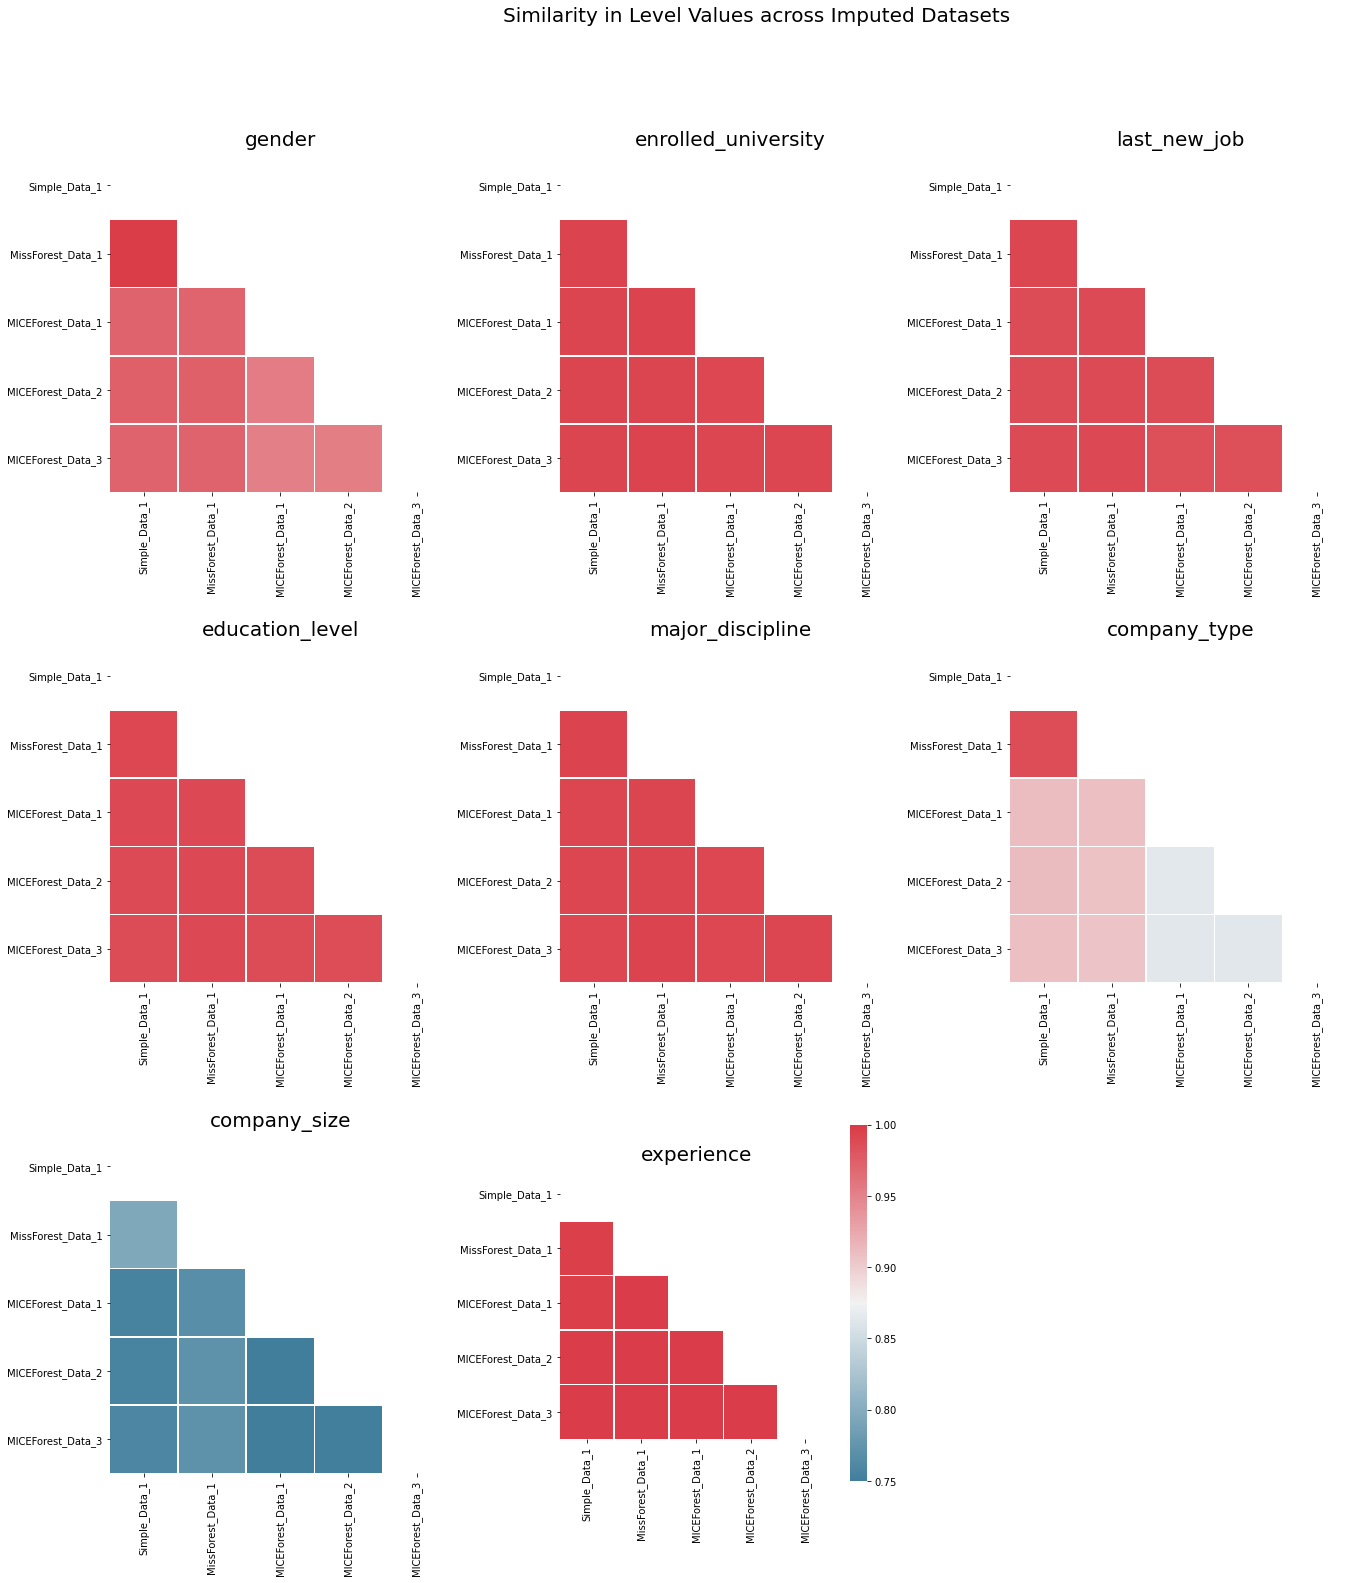

In [21]:
catvars_with_missing = ['gender','enrolled_university','last_new_job','education_level','major_discipline','company_type','company_size','experience']
imputed_all = [(key+'_'+'Data_'+str(counter+1), item) for key in imputed_data.keys() for counter, item in enumerate(imputed_data[key])] 
counter = len(imputed_all)

cmap = sns.diverging_palette(230, 10, as_cmap = True)
fig, ax = plt.subplots(3,3, figsize = (7*3, 7*3), sharex = True, sharey = True)
#cbar_ax = fig.add_axes(list(np.arange(0.70, 1.0, 0.1)))
for count, item in enumerate(catvars_with_missing):
    
    # Create a holder for the data
    newframe = np.zeros((counter, counter))
    
    # Now fill the data holder
    for i in np.arange(counter):
        for j in np.arange(counter):
            if(i>j):
                newframe[i,j] = sum((imputed_all[i][1][item]==imputed_all[j][1][item]).astype('int'))/len(imputed_all[0][1])
    
    newframe = pd.DataFrame(newframe, columns = [imputed_all[i][0] for i in np.arange(len(imputed_all))])
    newframe.index = [imputed_all[i][0] for i in np.arange(len(imputed_all))]
    
    mask = np.triu(np.ones_like(newframe, dtype = bool))
    plt.subplot(3, 3, count + 1)
    g = sns.heatmap(newframe, mask = mask, cmap = cmap, square = True, linewidth = 0.5, 
                    vmin = 0.75, vmax = 1.0, cbar = True if count==len(catvars_with_missing)-1 else False)
    g.set_title(item, fontsize = 20)

fig.delaxes(ax[2][2])
plt.suptitle('Similarity in Level Values across Imputed Datasets', fontsize = 20, y = 1.05)
fig.tight_layout(rect=[0, 0, .9, 1])
plt.show()

The figure above shows that the imputed datasets are quite similar in most features, with more than 90% of similarity in level values in their observations. The only feature where the imputed datasets are marginally different is 'company_size'. In fact, even for the same type of imputation method - 'MICEForest', there are differences between the 3 imputations. However, even for this feature, over 75% of observation values are similar across imputed datasets. 

Next, we plot the level frequencies of each of these categorical features for different imputed datasets, and compare them to the level frequencies of the original dataset after dropping the missing values. 

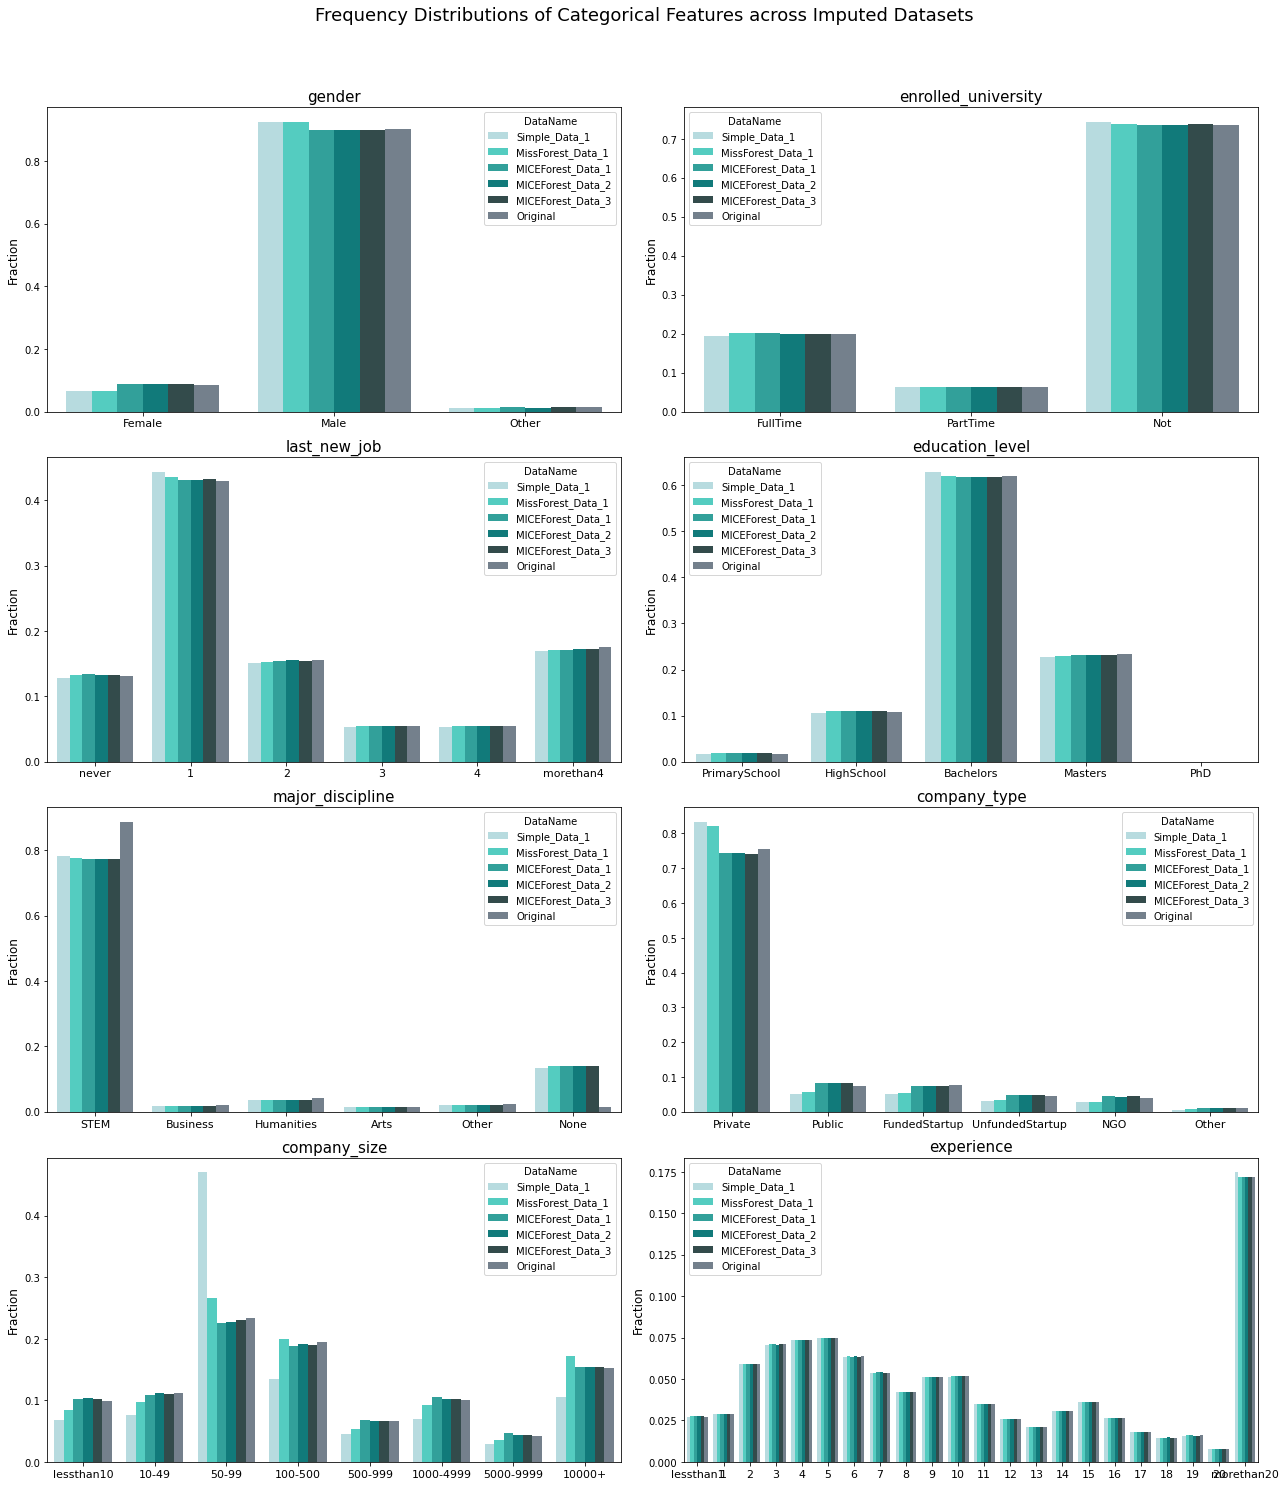

In [22]:
# Method used to plot:
    
#     1. For each data, count the fraction of observations in each level for a particular feature. 
#     2. Save each data-feature combination as a frame with dataname, featurename, fraction. 
#     3. Keep appending to the saved frame for each imputed dataset. 
#     4. Plot the above frame, ordering the levels as required. 
#     5. Do the same above for each feature. 

hue_order = [name for (name,_) in imputed_all]+['Original']
level_order = {'gender':['Female','Male','Other'], 
               'enrolled_university':['FullTime','PartTime','Not'], 
               'last_new_job':['never','1','2','3','4','morethan4'], 
               'education_level':['PrimarySchool','HighSchool','Bachelors','Masters','PhD'], 
               'major_discipline':['STEM','Business','Humanities','Arts','Other','None'], 
               'company_type':['Private','Public','FundedStartup','UnfundedStartup','NGO','Other'],
               'company_size':['lessthan10','10-49','50-99','100-500','500-999','1000-4999','5000-9999','10000+'], 
               'experience':['lessthan1']+[str(i) for i in np.arange(1,21,1)]+['morethan20']}
color = ['powderblue','turquoise','lightseagreen','darkcyan','darkslategray','slategrey']
leglabels = []

fig, ax = plt.subplots(4,2, figsize = (9*2, 5*4))
for counter, item in enumerate(catvars_with_missing):
    
    newframe = pd.DataFrame({item:[], 'Fraction':[], 'DataName':[]})
    for i, (name, frame) in enumerate(imputed_all):
        tempframe = (frame[item].value_counts()/len(frame)).reset_index()
        tempframe.columns = [item, 'Fraction']
        tempframe['DataName'] = [name for _ in np.arange(frame[item].nunique())]        
        newframe = pd.concat([newframe, tempframe], axis = 0, ignore_index = True)
        
    tempframe = (Data[item].value_counts(dropna = True)/len(Data.dropna(subset = [item], axis = 0, inplace = False))).reset_index()
    tempframe.columns = [item, 'Fraction']
    tempframe['DataName'] = ['Original' for _ in np.arange(Data.dropna(subset = [item], axis = 0, inplace = False)[item].nunique())]
    newframe = pd.concat([newframe, tempframe], axis = 0, ignore_index = True)    
    
    plt.subplot(4,2,counter+1)
    g = sns.barplot(data = newframe, x = item, y = 'Fraction', hue = 'DataName', order = level_order[item], palette = color)
    g.set_title(item, fontsize = 15)
    g.set_ylabel('Fraction', fontsize = 12)
    g.set_xlabel('')
    g.set_xticklabels(level_order[item], fontsize = 11)
plt.suptitle('Frequency Distributions of Categorical Features across Imputed Datasets', fontsize = 18, y = 1.03)    
plt.tight_layout()
plt.show()

del [newframe, tempframe]

The density graphs above show that every imputation method produces datasets which have the same level distributions as the original dataset. And this is true for almost every categorical feature. The only two features where these similarities break down are major_discipline and company_size. In the former, all imputation methods underestimate STEM observations and over-estimate the None category. However, this is not incorrect because we have used feature consistency on these imputed datasets and not on the original dataset. For the other feature (company_size) the Simple Imputation method vastly overestimates the 50-99 category in comparison to all other imputation methods, and the original dataset as well. 

All in all, these imputation methods do not produce wildly different datasets among each other and from the original dataset. 

### (B) Relationship between Outcome and Features

In this section I investigate the relationship between the outcome ('target') and the feature variables, and the relationship between combinations of features, to understand which features have the greatest contribution to exit decisions and how do they affect exit decisions. 


In particular I conduct the list of following analyses:

1. Proportion of exits in the full data. 
2. Difference in the numeric features between those who exit and those stay (Visual Tests + Statistical Tests)
3. Differences in the proportion of exits across different levels of the same categorical feature (Visual Tests + Statistical Tests)
4. Correlation between numeric features separately for those who exit and those who stay. 
5. Bivariate Distributions across combinations of select categorical features. 
6. Evaluation of feature contribution to exit decision using linear probability model and simple logistic regression model. 
7. Comparison of feature contribution to exit decisions across statistical models and imputed datasets. 

Since, I have multiple imputed datasets, it will be cumbersome to show the analyses above for each imputed dataset. Therefore, I choose the MissForest imputed dataset to conduct all these analyses above. Since the imputed datasets do not differ much from each other, I can be confident that the results would not be too skewed when using the MissForest dataset alone. I verify this for point numbers (6) and (7) above. More specifically, I conduct these regressions for all the 5 imputed datasets and show the effects of features on exit decisions in the same graph. 

I will work with the MissForest Dataset, and look at the relationship between the various features and target variables in that dataset. 

#### (B.1) Proportion of Exits in Full Dataset

Percentage of data scientists who leave after training: 24.935%



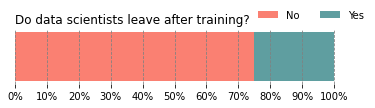

In [23]:
# (1) Proportion of data scientists who leave

print('Percentage of data scientists who leave after training: {:2.3%}\n'.format(Data['target'].sum()/len(Data)))

# show this percentage graphically

df = Data['target'].value_counts()/len(Data) 
fracLeave = pd.DataFrame({df.index[0]:[df[0]], df.index[1]:[df[1]]})
fracLeave.columns = ['No','Yes']
fields = fracLeave.columns.to_list()
colors = colors = ['salmon', 'cadetblue']
left = len(fracLeave)*[0]

fig, ax = plt.subplots(figsize = (6, 1))
for idx, name in enumerate(fields):
    #print(fracLeave.index, fracLeave[name]) 
    plt.barh(fracLeave.index, fracLeave[name], left = left, color = colors[idx])
    left = left + fracLeave[name]
plt.title('Do data scientists leave after training?', loc = 'left')
plt.legend(fields, ncol = 2, frameon = False, bbox_to_anchor = ([0.7, 1.0, 0., 0.]))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
xticks = np.arange(0,1.1,0.1)
xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
plt.xticks(xticks, xlabels)
ax.get_yaxis().set_ticks([])
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

del [df, fracLeave, fields, colors, left, idx, name, fig, ax]
    

In [24]:
tempdata = imputed_data['MissForest'][0].copy(deep = True)
tempdata = pd.concat([tempdata, Data['target']], axis = 1)
tempdata.columns

Index(['city', 'city_development_index', 'gender', 'relevant_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

#### (B.2a) Visual Tests of Differences in Numeric Features Between Leavers and Stayers 

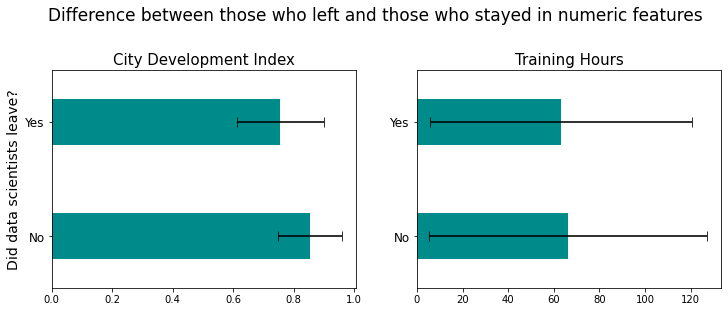

In [25]:
## Now we draw bar charts that show the average training hours and city_development_index by exit type 
## with standard errors and also conduct some statistical checks on these differences. 

df = tempdata[['target','city_development_index','training_hours']].groupby('target').agg([np.mean, np.std]).reset_index()
df.columns = ['Exit','citydevindexmean','citydevindexstd','trainhrsmean','trainhrsstd']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
df.plot(kind = 'barh', y = 'citydevindexmean', ax = ax1, legend = False, width = 0.4, color = 'darkcyan')
ax1.errorbar(df["citydevindexmean"], df.index, xerr = df["citydevindexstd"], 
             linewidth = 2, color = "black", alpha = 0.8, capsize = 5, fmt = 'none')
ax1.set_title('City Development Index', fontsize = 15)
ax1.set_yticklabels(['No','Yes'], fontsize = 12)
ax1.set_ylabel('Did data scientists leave?', fontsize = 14)

df.plot(kind = 'barh', y = 'trainhrsmean', ax = ax2, legend = False, width = 0.4, color = 'darkcyan')
ax2.errorbar(df["trainhrsmean"], df.index, xerr = df["trainhrsstd"], 
             linewidth = 2, color = "black", alpha = 0.8, capsize = 5, fmt = 'none')
ax2.set_title('Training Hours', fontsize = 15)
ax2.set_yticklabels(['No','Yes'], fontsize = 12) 

plt.suptitle('Difference between those who left and those who stayed in numeric features', y = 1.1, fontsize = 17);

#### (B.2b) Statistical Tests of Differences in Numeric Features between Stayers and Leavers

Here, I check whether the difference between the average measures of each numeric feature for Stayers and Leavers is statistically significant. This can be done using the independent t-test, which is applicable if the numeric feature separately follows the normal distribution for Stayers and Leavers, and the sample size is large enough. The sample sizes are indeed large enough to apply t-tests if normality is not violated. If however, the distributions are not individually normal, then we should apply non-parameteric tests.  

Therefore, I follow the following steps in conducting these statistical tests:

1. For each numeric feature and exit type, I conduct visual tests of normality by plotting histograms and Q-Q plots. 
2. For each numeric feature and exit type, I further conduct formal tests of normality using the Shapiro-Wilk Test. 
3. If for a particular numeric feature, normality is satisfied for both Stayers and Leavers, then I conduct the independent t-test (two-sided) and if the p-value <= 0.05, then I conclude that the mean of the numeric feature is statistically different between Stayers and Leavers. 
4. If for a particular numeric feature, normality is violated for at least one among Stayers and Leavers, then I conduct the two-Sample Mann-Whitney-U test, which is a non-parameteric test to compare the distributions of the numeric feature between Stayers and Leavers. If the p-value <= 0.05, then I conclude that the distribution of the numeric feature differs significantly between Stayers and Leavers. 

##### Visual Tests of Normality of Numeric Features (Histogram + Quantile-Quantile Plots)

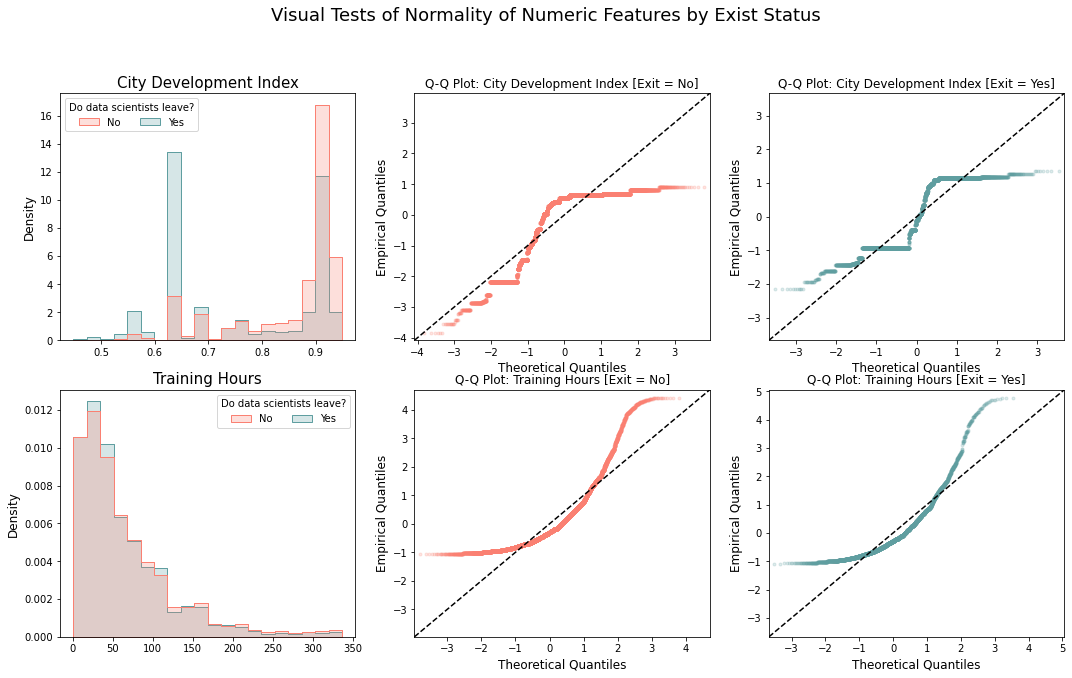

In [26]:
## First we check whether the distributions of the numeric feature are normal separately for those who exit and those who stayed
# To check for normality we do the following: (1) histogram, (2) Q-Q plot, (3) Shapiro-Wilk test

fig, ax = plt.subplots(2, 3, figsize = (18, 10))
ax1 = ax[0][0]
ax2 = ax[1][0]
ax3 = ax[0][1]
ax4 = ax[0][2]
ax5 = ax[1][1]
ax6 = ax[1][2]

g = sns.histplot(tempdata, x = 'city_development_index', hue = 'target', stat = 'density', element = 'step', 
            bins = 20, common_norm = False, palette = ['salmon','cadetblue'], ax = ax1)
ax1.set_title('City Development Index', fontsize = 15)
ax1.set_xlabel('')
ax1.set_ylabel('Density', fontsize = 12)
legend = g.get_legend()
handles = legend.legendHandles
#legend.remove()
ax1.legend(handles, ['No','Yes'], title = 'Do data scientists leave?', loc = 'upper left', ncol = 2);

f = sns.histplot(tempdata, x = 'training_hours', hue = 'target', stat = 'density', element = 'step', 
                bins = 20, common_norm = False, palette = ['salmon', 'cadetblue'], ax = ax2)
ax2.set_title('Training Hours', fontsize = 15)
ax2.set_xlabel('')
ax2.set_ylabel('Density', fontsize = 12)
legend2 = g.get_legend()
handles = legend2.legendHandles
#legend2.remove()
ax2.legend(handles, ['No','Yes'], title = 'Do data scientists leave?', loc = 'upper right', ncol = 2);

h = sm.ProbPlot(tempdata.loc[tempdata['target']==0,:]['city_development_index'], fit = True)
qq = h.qqplot(marker = '.', markerfacecolor = 'salmon', markeredgecolor = 'salmon', alpha = 0.2, ax = ax3)
sm.qqline(line = '45', fmt = 'k--', ax = ax3)
ax3.set_title('Q-Q Plot: City Development Index [Exit = No]')
ax3.set_xlabel('Theoretical Quantiles', fontsize = 12)
ax3.set_ylabel('Empirical Quantiles', fontsize = 12)

h = sm.ProbPlot(tempdata.loc[tempdata['target']==1,:]['city_development_index'], fit = True)
qq = h.qqplot(marker = '.', markerfacecolor = 'cadetblue', markeredgecolor = 'cadetblue', alpha = 0.2, ax = ax4)
sm.qqline(line = '45', fmt = 'k--', ax = ax4)
ax4.set_title('Q-Q Plot: City Development Index [Exit = Yes]')
ax4.set_xlabel('Theoretical Quantiles', fontsize = 12)
ax4.set_ylabel('Empirical Quantiles', fontsize = 12)

h = sm.ProbPlot(tempdata.loc[tempdata['target']==0,:]['training_hours'], fit = True)
qq = h.qqplot(marker = '.', markerfacecolor = 'salmon', markeredgecolor = 'salmon', alpha = 0.2, ax = ax5)
sm.qqline(line = '45', fmt = 'k--', ax = ax5)
ax5.set_title('Q-Q Plot: Training Hours [Exit = No]')
ax5.set_xlabel('Theoretical Quantiles', fontsize = 12)
ax5.set_ylabel('Empirical Quantiles', fontsize = 12)

h = sm.ProbPlot(tempdata.loc[tempdata['target']==1,:]['training_hours'], fit = True)
qq = h.qqplot(marker = '.', markerfacecolor = 'cadetblue', markeredgecolor = 'cadetblue', alpha = 0.2, ax = ax6)
sm.qqline(line = '45', fmt = 'k--', ax = ax6)
ax6.set_title('Q-Q Plot: Training Hours [Exit = Yes]')
ax6.set_xlabel('Theoretical Quantiles', fontsize = 12)
ax6.set_ylabel('Empirical Quantiles', fontsize = 12)

plt.suptitle('Visual Tests of Normality of Numeric Features by Exist Status', fontsize = 18, y = 1.0);

##### Takeaway:

The histogram and QQ plots above for the two numeric features, separately by exit status, show that both numeric features do not follow the normal distribution for either exit status. Below I use the Shapiro Wilk test to conduct a more robust statistical check for whether normality is satisfied for these two numeric features. 

##### Formal Statistical Tests of Normality of Numeric Features (Shapiro Wilk Test)

In [27]:
# Shapiro-Wilk Test for each numeric feature, separately by exit type
print('Shapiro Wilk Test for normality. H0: Distribution is normal, H1: Distribution is not normal.\n')

ShapiroWilk = scipy.stats.shapiro(tempdata.loc[tempdata['target']==0,:]['city_development_index'])
print('City Development Index - Exit Status: No')
print('Test Statistic: {:1.4}'.format(ShapiroWilk[0]), ' p-value: {:1.4}'.format(ShapiroWilk[1]),'\n')
ShapiroWilk = scipy.stats.shapiro(tempdata.loc[tempdata['target']==1,:]['city_development_index'])
print('City Development Index - Exit Status: Yes')
print('Test Statistic: {:1.4}'.format(ShapiroWilk[0]), ' p-value: {:1.4}'.format(ShapiroWilk[1]),'\n')
ShapiroWilk = scipy.stats.shapiro(tempdata.loc[tempdata['target']==0,:]['city_development_index'])
print('Training Hours - Exit Status: No')
print('Test Statistic: {:1.4}'.format(ShapiroWilk[0]), ' p-value: {:1.4}'.format(ShapiroWilk[1]),'\n')
ShapiroWilk = scipy.stats.shapiro(tempdata.loc[tempdata['target']==1,:]['city_development_index'])
print('Training Hours - Exit Status: Yes')
print('Test Statistic: {:1.4}'.format(ShapiroWilk[0]), ' p-value: {:1.4}'.format(ShapiroWilk[1]),'\n')

Shapiro Wilk Test for normality. H0: Distribution is normal, H1: Distribution is not normal.

City Development Index - Exit Status: No
Test Statistic: 0.7228  p-value: 0.0 

City Development Index - Exit Status: Yes
Test Statistic: 0.8224  p-value: 0.0 

Training Hours - Exit Status: No
Test Statistic: 0.7228  p-value: 0.0 

Training Hours - Exit Status: Yes
Test Statistic: 0.8224  p-value: 0.0 



##### Takeaway:

The four Shapiro Wilk tests above further confirm that the two numeric features are not normally distributed, for either exit status. Therefore, instead of testing for the statistical significance of the difference between the means of each numeric variable by exit status, I use a non-parameteric test for the equality of the distributions of each numeric variable by exit status. More specifically, I use the Mann-Whitney-U test. 

##### Formal Non-Parameteric Statistical Tests of Distributional Similarity (Mann-Whitney-U Test)

In [28]:
print('Non-Parameteric Mann-Whitney-U Test for equality of distributions between exit status:\n')

MWU = scipy.stats.mannwhitneyu(tempdata.loc[tempdata['target']==0,:]['city_development_index'], 
                         tempdata.loc[tempdata['target']==1,:]['city_development_index'], use_continuity = True, alternative = 'two-sided')
print('City Development Index - Test Statistic: {:1.4}'.format(MWU[0]), 'p-value: {:1.4}'.format(MWU[1]))
MWU = scipy.stats.mannwhitneyu(tempdata.loc[tempdata['target']==0,:]['training_hours'], 
                         tempdata.loc[tempdata['target']==1,:]['training_hours'], use_continuity = True, alternative = 'two-sided')
print('Training Hours - Test Statistic: {:1.4}'.format(MWU[0]), 'p-value: {:1.4}'.format(MWU[1]))

Non-Parameteric Mann-Whitney-U Test for equality of distributions between exit status:

City Development Index - Test Statistic: 4.699e+07 p-value: 0.0
Training Hours - Test Statistic: 3.5e+07 p-value: 0.05056


##### Takeaway:

The Mann-Whitney-U tests above show that the distribution for 'city_development_index' is significantly different for those who exit and those stay, since the p-value is less than 0.05 (which is the alpha level for the 95% confidence level). However, the distribution for 'training_hours' is significantly different between those who stay and those who leave, only at the 10% significance level and not at the 5% level, because the p-value lies between 0.05 and 0.1.   

#### (B.3) Differences in Proportion of Exits Between Different Levels of Categorical Features

Next, I check whether the proportions of data scientists who leave within each level of a given categorical feature differ. I do this in two ways:
1. Visualization of fraction that leaves for each level of the categorical feature.
2. Statistical Tests of differences in these proportions across levels of the categorical feature.

##### (B.3a) Visual Checks of Difference in Proportion of Exits between Levels of Same Categorical Feature

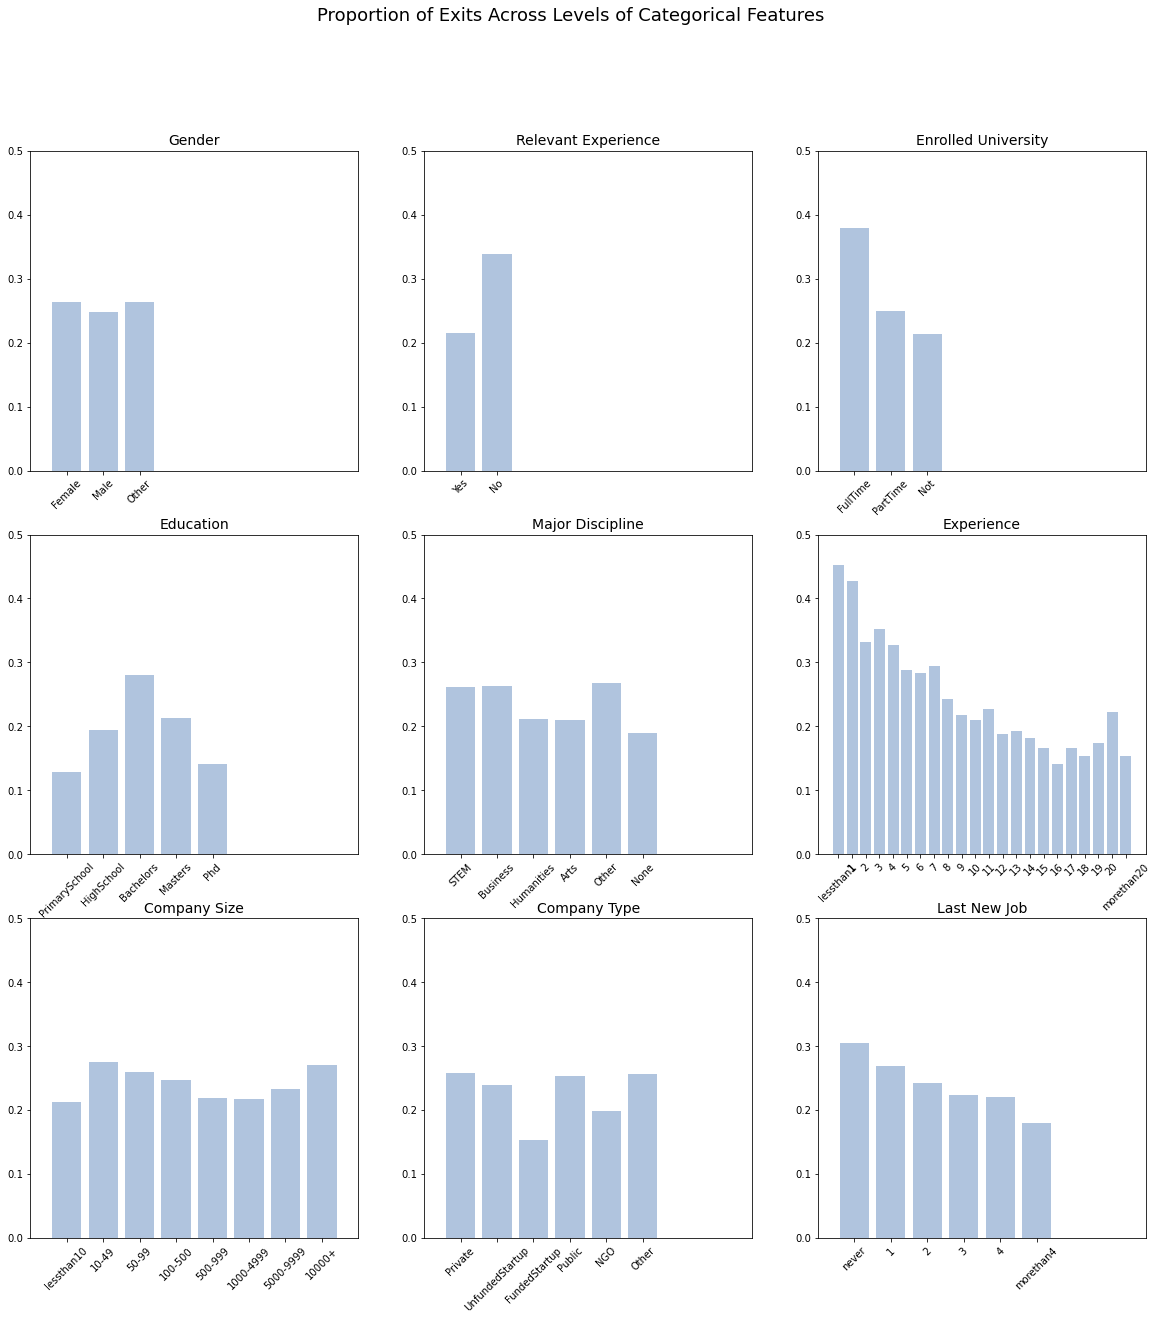

In [29]:
## (1) Visualization of proportion of exits across levels of each categorical variable

# First find the number of features which are categorical, except for city
namecatvars = ['Gender','Relevant Experience','Enrolled University','Education','Major Discipline','Experience',
               'Company Size','Company Type','Last New Job']
catvarlevels = {'gender':['Female','Male','Other'],
                'relevant_experience':['Yes','No'], 
                'enrolled_university':['FullTime','PartTime','Not'], 
                'education_level':['PrimarySchool','HighSchool','Bachelors','Masters','Phd'],
                'major_discipline':['STEM','Business','Humanities','Arts','Other','None'], 
                'experience':['lessthan1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','morethan20'], 
                'company_size':['lessthan10','10-49','50-99','100-500','500-999','1000-4999','5000-9999','10000+'], 
                'company_type':['Private','UnfundedStartup','FundedStartup','Public','NGO','Other'], 
                'last_new_job':['never','1','2','3','4','morethan4']}
# maxlevels = 0
# for key, value in catvarlevels.items():
#     if(len(value)>maxlevels):
#         maxlevels = len(value)

fig, ax = plt.subplots(3, 3, figsize = (20, 20))

for counter, item in enumerate([x for x in catvars if x != 'city']):
    
    i = int(counter/3)
    j = counter-3*i  
        
    # First create the 
    df = (tempdata[[item, 'target']].groupby(item).sum('target')/tempdata[[item, 'target']].groupby(item).count())
    df = df.reindex(catvarlevels[item]).reset_index() 
    
    ax[i][j].bar(x = df[item], height = df['target'], width = 0.8, color = 'lightsteelblue')
    ax[i][j].set_title(namecatvars[counter], fontsize = 14)
    if(len(catvarlevels[item])<=8):
        ax[i][j].set_xlim(-1,8)
    ax[i][j].set_ylabel('')
    ax[i][j].set_xlabel('')
    ax[i][j].set_ylim(0, 0.50)
    ax[i][j].tick_params(axis = 'x', labelrotation = 45)
    
plt.suptitle('Proportion of Exits Across Levels of Categorical Features', fontsize = 18);   

##### (B.3b) Formal Statistical Checks of Difference in Proportion of Exits between Levels of Categorical Features

Next, I show whether the proportion of exits differ significantly between any two levels of each categorical feature. I conduct this analyses using the [Marascuillo procedure](https://www.itl.nist.gov/div898/handbook/prc/section4/prc474.htm), which can be used to compare two or more proportions. I then show results from this analyses in the form of a heatmap for each categorical feature. The heatmap shows whether any two levels of a particular categorical feature differ significantly in their proportions of exits at the two-sided 95% confidence levels (or, two-sided 5% significance level). 

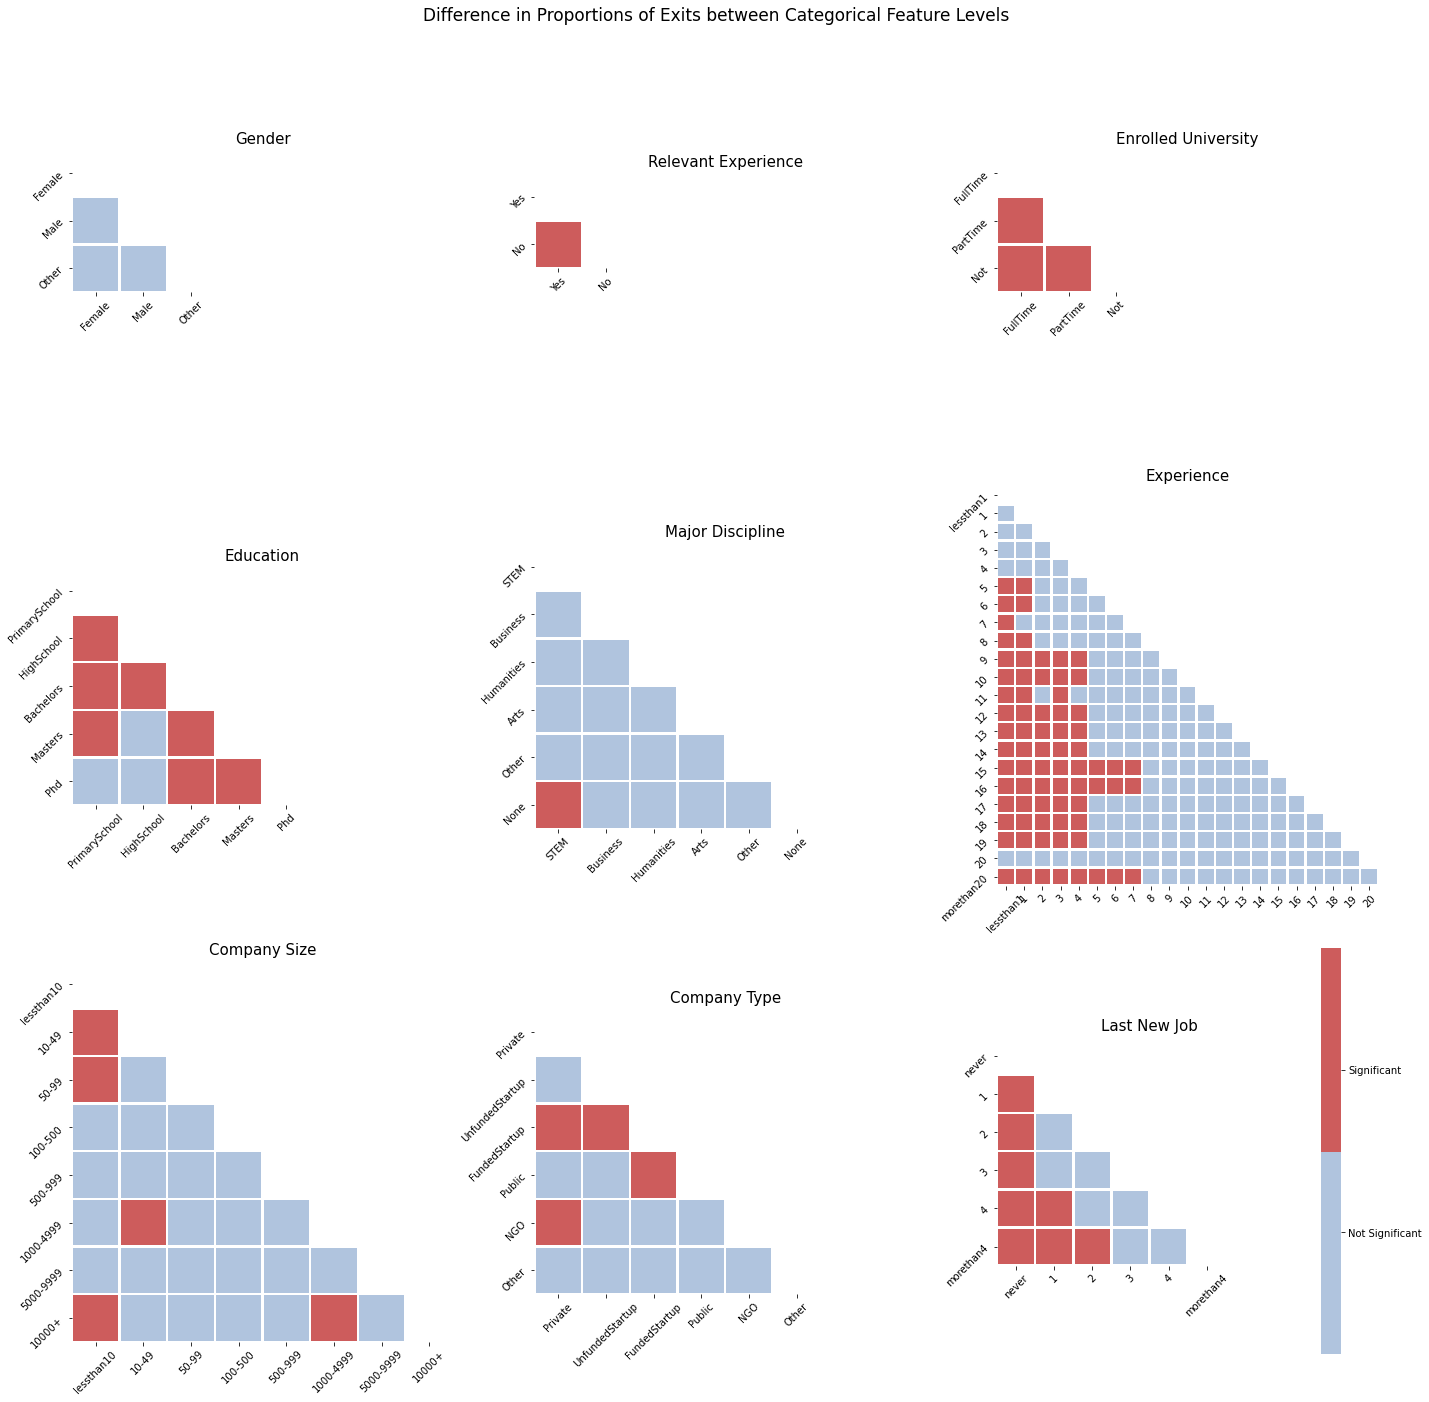

In [30]:
siglevel = 0.95
#cmap = sns.diverging_palette(230, 10, as_cmap = True)
cmap = sns.color_palette("deep", 2)
#print(cmap)
cmap = ['lightsteelblue','indianred']

fig, ax = plt.subplots(3, 3, figsize = (20, 20))

for counter, item in enumerate([x for x in catvars if x != 'city']):
    
    i = int(counter/3)
    j = counter-3*i
    lenlevels = len(catvarlevels[item])
    
    # First, create a dataframe which has rows and columns the same as levels of the feature
    newframe = np.zeros((lenlevels, lenlevels))
        
    # Second, fill the dataframe with a dummy of whether the two proportions are different or not
    for counter1 in np.arange(lenlevels):
        for counter2 in np.arange(lenlevels):
            if(counter1 > counter2):
                df1 = tempdata.loc[tempdata[item]==catvarlevels[item][counter1],:]
                df2 = tempdata.loc[tempdata[item]==catvarlevels[item][counter2],:]
                p1 = sum(df1['target'])/len(df1)
                p2 = sum(df2['target'])/len(df2)
                r = ((scipy.stats.chi2.ppf(siglevel, lenlevels-1))*(p1*(1-p1)/len(df1)+p2*(1-p2)/len(df2)))**0.5               
                newframe[counter1,counter2] = 1*(abs(p1-p2)>r) 
                
    # Now create a mask which masks the upper triangulae matrix
    mask = np.triu(np.ones_like(newframe, dtype = bool))
    
    # Now plot the graph
    g = sns.heatmap(newframe, mask = mask, cmap = cmap, square = True, linewidth = 1.5, ax = ax[i][j], vmin = 0, vmax = 1, 
                    cbar = True if counter==len(namecatvars)-1 else False, 
                    xticklabels = catvarlevels[item], yticklabels = catvarlevels[item])               
    ax[i][j].set_title(namecatvars[counter], fontsize = 15)
    if(lenlevels <= 8):
        ax[i][j].set_xlim(0,8)
        #ax[i][j].set_ylim(0,8)
    else:
        ax[i][j].set_xlim(0,21)
        #ax[i][j].set_ylim(0,21)
    ax[i][j].tick_params(axis = 'both', rotation = 45)   
    if(counter==len(namecatvars)-1):
        colorbar = ax[i][j].collections[0].colorbar
        colorbar.set_ticks([0.3, 0.7])
        colorbar.set_ticklabels(['Not Significant', 'Significant'])
    
plt.suptitle('Difference in Proportions of Exits between Categorical Feature Levels', fontsize = 17)    
plt.tight_layout()
plt.show()

##### Takeaway:

The heatmaps above show that for most categorical features, there are combinations of levels such that the proportions of exits differ between them. 'Gender' is one categorical feature which does not seem to have much difference in the proportion of exits across its levels. This is also evident in the bar graphs shown above where the bars have almost the same height across levels for the feature 'Gender'. For the feature 'Last New Job', the bar graphs above show that the proportion of exits decrease as the duration of the 'last new job' increases. This is captured quite precisely in the heatmap here. Between two consecutive levels of this feature, there is little difference in the proportion of exits shown as 'blue' at the right edge of the triangle. However, when we compare levels that are far apart in duration, the proportions are clearly quite different, as evident by the 'red' labels towards the left edge of the triangle. 

Overall, the heatmaps above suggest that levels of categorical features do have different correlations with exit decisions and therefore should potentially be accounted for in the classification problem. I will explore this idea in more detail in later analyses. 

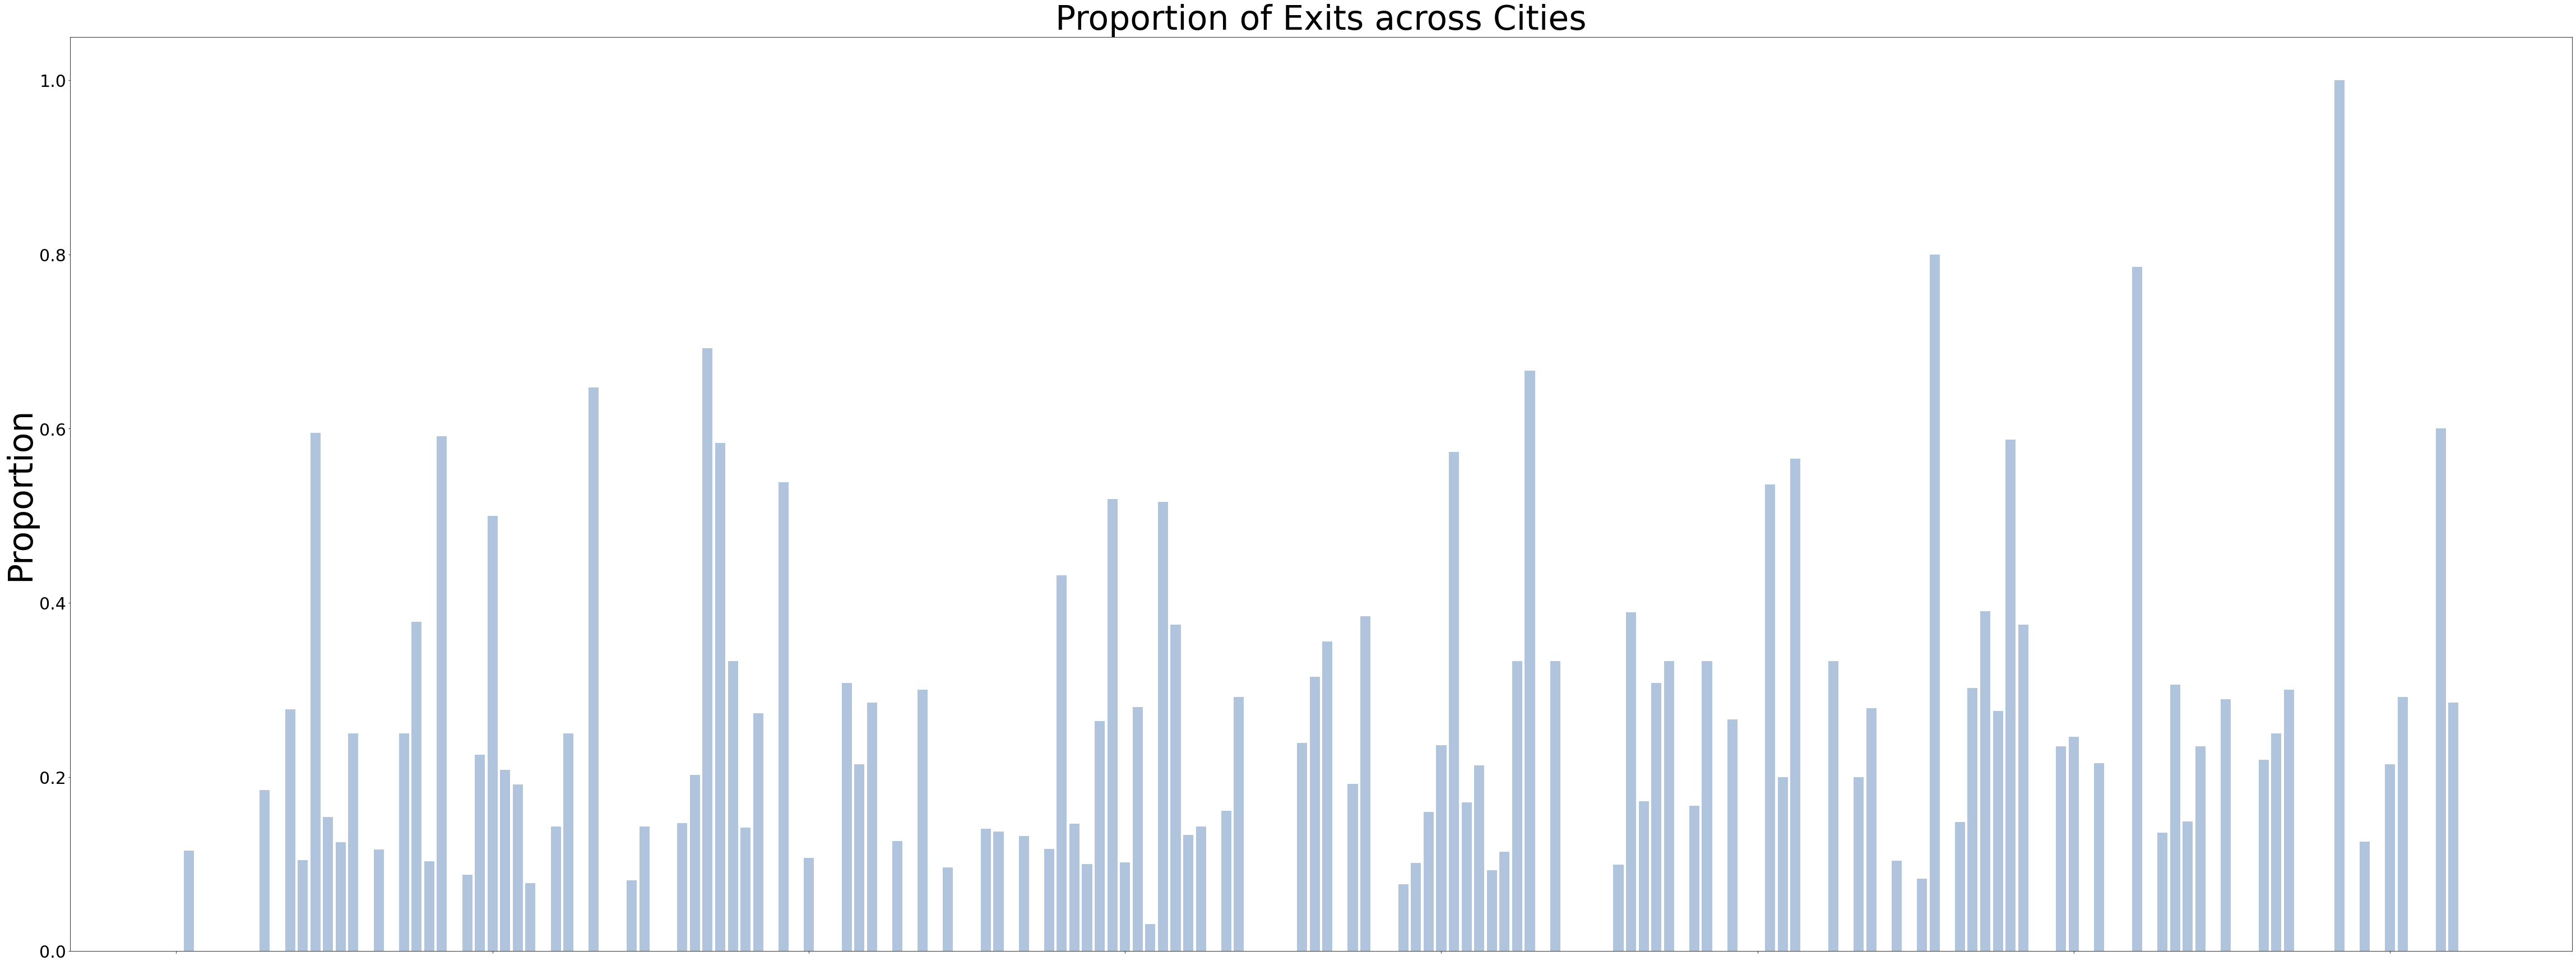

In [31]:
# Now find the fraction of exits in each city

df = tempdata[['city','target']].groupby('city').sum('target')/tempdata[['city','target']].groupby('city').count()
df = df.reset_index()
df['city'] = df['city'].astype(float).astype("Int64")
df = df.iloc[df['city'].argsort(),:]
# df['city'] = df['city'].astype('category') 

# Now plot a bar graph
fig, ax = plt.subplots(figsize = (80, 30))
ax.bar(x = df['city'], height = df['target'], width = 0.8, color = 'lightsteelblue')
ax.set_title('Proportion of Exits across Cities', fontsize = 60) 
ax.set_ylabel('Proportion', fontsize = 60)
ax.set_xlabel('')
ax.tick_params(labelsize = 30)
ax.set_xticklabels([]);

##### Takeaway:

Again, the main takeaway from the figure above is that there is considerable heterogeneity in the proportion of data scientists who leave, across cities and there seems to be only one city where all data scientists leave.

#### (B.4) Relationship between Numeric Features

Is there a relationship between the numeric features themselves, particularly within exit types?

This is an important question to answer, because if two features are perfectly correlated (either negative or positive), then the use of one feature in the classification problem becomes redundant in the presence of the other. So I want to explore the correlations between features, both numeric and categorical. To do this, I conduct the following three types of visual analyses:

1. Check for correlations between different numeric features. 
2. Check for correlations between levels of different categorical features. 
3. Check for correlations between numeric features and categorical features. 

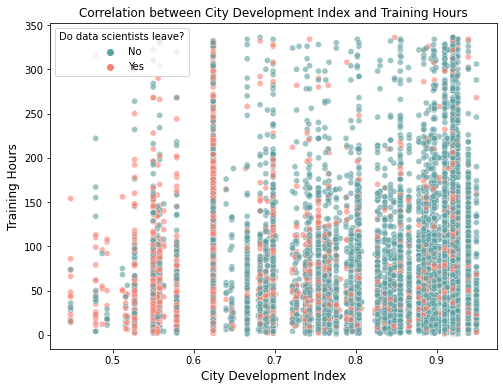

In [32]:
# (1) Scatter Plot of numeric features

fig, ax = plt.subplots(figsize = (8,6))
g = sns.scatterplot(x = 'city_development_index', y = 'training_hours', hue = 'target', data = tempdata, 
                   palette = ['cadetblue','salmon'], alpha = 0.6, ax = ax, legend = True)
ax.set_title('Correlation between City Development Index and Training Hours')
ax.set_xlabel('City Development Index', fontsize = 12)
ax.set_ylabel('Training Hours', fontsize = 12)
legend = g.get_legend() 
handles = legend.legendHandles 
ax.legend(handles, ['No','Yes'], title = 'Do data scientists leave?', loc = 'upper left', ncol = 1);

##### Takeaway:

The scatterplot above shows that there is little correlation between the two numeric features - city development index and training hours, for either those who exit and those who stay back. 

#### (B.5) Relationship between Categorical Features

Next, I investigate the correlations between the levels of any two categorical features. This can be done using cross tabulating two categorical features and then visualizing these cross tabulations. Since there are 9 categorical features of importance, I would have to analyse these correlations for 9(C)2 (read as, 9 Combination 2) or 36 different combinations. This is an arduous task and would probably not lend itself to much interpretation. Therefore, I restrict our analyses to cross-tabulations of combinations that make more sense. In order to analyse whether these cross tabulations differ by exit status, I conduct these analyses separately by exit status. In particular I conduct this analyses for the following combinations of categorical features: 

* Enrolled University v/s Major Discipline 
* Experience v/s Last New Job 
* Company v/s and Company Type

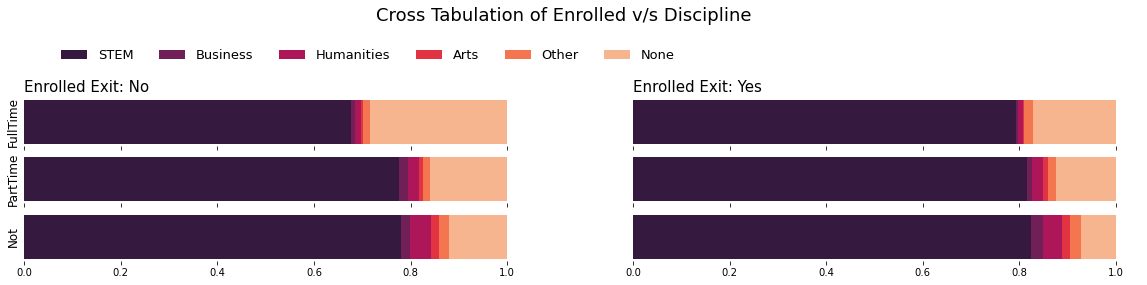

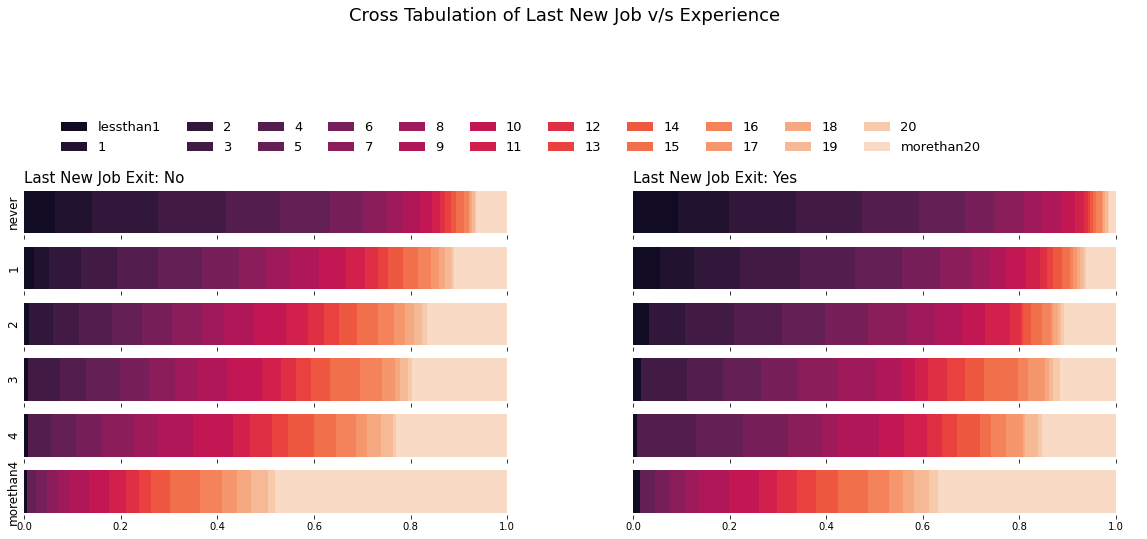

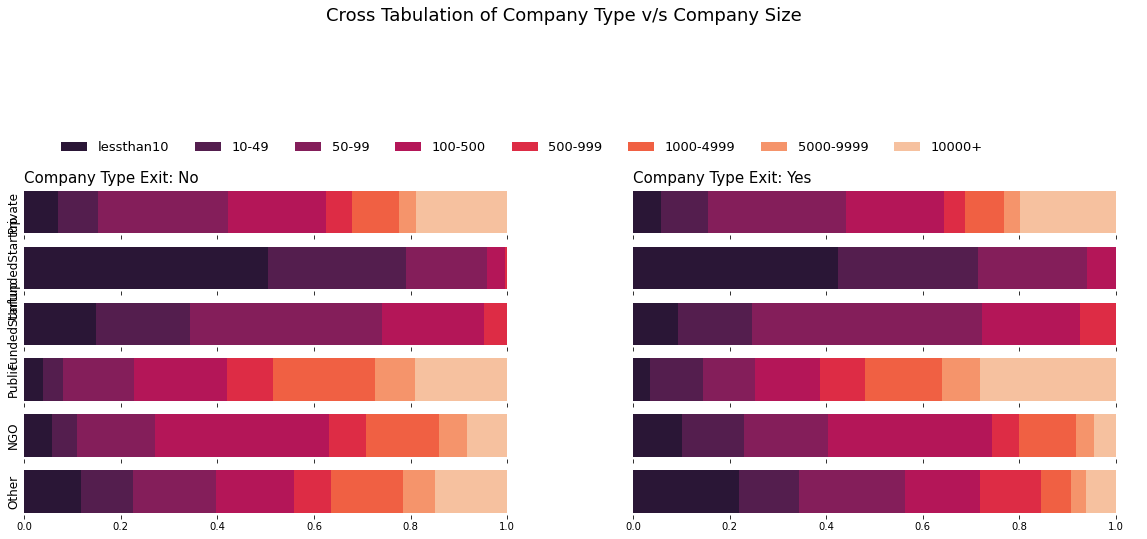

In [33]:
# (1) Relation between enrolled university and major discipline 
# Put enrolled university as the x axis, and then find the frequency of major discipline within 

def plotCrossTab(firstvar, secondvar, dataset, firstname, secondname):
    
    # First create a graph environment where the number of rows will be equal to the unique levels in firstvar
    lenlevels = len(catvarlevels[firstvar])
    lenparts = len(catvarlevels[secondvar])
    fig, ax = plt.subplots(lenlevels, 2, figsize = (10*2, 1*lenlevels))
    
    listaxes = ax.flatten()    
    
    # Now create a color palette with the same number of colors as 
    colors = sns.color_palette("rocket", lenparts)
    
    # Now iterate over the two levels of the outcome variable
    for outcome in np.arange(2):
        
        # Define the exit status string to be used in names later
        if(outcome == 0):
            exitname = 'No'
        else:
            exitname = 'Yes'
            
        # Now first create a dataframe which contains proportions
        Totals = dataset.loc[dataset['target']==outcome,:][firstvar].value_counts()
        df = pd.crosstab(dataset.loc[dataset['target']==outcome,:][firstvar], 
                         dataset.loc[dataset['target']==outcome,:][secondvar]).stack().reset_index().set_index(firstvar)
        df['Totals'] = Totals 
        df['Proportion'] = df[0]/df['Totals'] 
        df.drop([0,'Totals'], axis = 1, inplace = True)

        
        # Define some of the graphing features
        fields = catvarlevels[secondvar]   
        
        # Iterate over the levels of the firstvar
        for idx1, name1 in enumerate(catvarlevels[firstvar]):
            tempdf = df.loc[df.index == name1, :].copy(deep = True)
            tempdf.set_index(secondvar, inplace = True)
            tempdf = tempdf.reindex(catvarlevels[secondvar])
            tempdf.reset_index(inplace = True)
            
            left = 1*[0]
            
            axes = listaxes[outcome+idx1*2]
            #print(axes)
            
            #print(sum(tempdf['Proportion']))
            
            # Now iterate over the levels of the secondvar
            for idx2, name2 in enumerate(catvarlevels[secondvar]):
                if(tempdf.loc[tempdf[secondvar] == name2,:].iloc[0,1] > 0.):
                #print(left, tempdf.loc[tempdf[secondvar] == name2,:].iloc[0,1])
                    axes.barh(pd.RangeIndex(0,1,1), tempdf.loc[tempdf[secondvar] == name2,:].iloc[0,1], 
                                           left = left, color = colors[idx2], height = 0.5)
                    left = left + tempdf.loc[tempdf[secondvar] == name2,:].iloc[0,1]
                
            axes.spines['right'].set_visible(False)
            axes.spines['left'].set_visible(False)
            axes.spines['top'].set_visible(False)
            axes.spines['bottom'].set_visible(False)
            if(idx1 == 0):
                axes.set_title(firstname+' Exit: '+exitname , loc = 'left', fontsize = 15)
            if(outcome == 0 and idx1 == 0):    
                axes.legend(fields, ncol = 11, frameon = False, bbox_to_anchor = ([0.05, 1.5, 0., 0.]), fontsize = 13)     
            axes.set_yticks([])
            if(outcome == 0):
                axes.set_ylabel(catvarlevels[firstvar][idx1], fontsize = 12)
                axes.tick_params(axis = 'y', labelrotation = 45)               
            if(idx1 == lenlevels - 1):
                xticks = np.arange(0,1.1,0.1)
                xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
            else:
                 axes.set_xticklabels([])

    plt.suptitle('Cross Tabulation of '+firstname+' v/s '+secondname, fontsize = 18, y = 1.3)
    
plotCrossTab('enrolled_university', 'major_discipline', tempdata, 'Enrolled', 'Discipline')
plotCrossTab('last_new_job', 'experience', tempdata, 'Last New Job', 'Experience')
plotCrossTab('company_type', 'company_size', tempdata, 'Company Type', 'Company Size')


##### Takeaway:

Again, the major takeaway here is that there appears to be some combinations of categorical features which have some discernible relationship between them, while other don't. For example, when comparing the duration of last new job and number of years of experience, it is evident that the employees who started their last new job years ago have a higher number of years of experience under their belt, than those who only recently started their last new job. This is quite an understandable fact. However, when I compare company type and company size, there does not seem to be any discernible pattern. 

The main point is that these categorical features, do not seem to be perfectly correlated with each other and therefore I might still find them individually useful in explaining exit decisions. 

#### (B.6) Feature Contribution to Exit Decisions 

##### How much do features contribute to data scientists' exit decisions? 

Here, I quantify the relative contribution of different numeric features and levels of categorical features, in explaining exit decisions. I do this, using simple logistic regression and a linear probability model (LPM). I run these regressions with 'Exit' as the outcome variable and use all numeric and categorical features as explanatory variables. While conducting this analysis, I standardize the numeric features to mean 0 and standard deviation 1, because I want to compare their effects in the regression to the levels of the categorical features. Also, for each categorical feature I define a base level, and the estimates for the other levels are increments over the base.  

In [34]:
# Define a formula 
baselevel_dict = {'city':'"103"',
                  'gender':'"Other"', 
                  'relevant_experience':'"No"', 
                  'last_new_job':'"never"', 
                  'company_type':'"Other"', 
                  'company_size':'"lessthan10"', 
                  'experience':'"lessthan1"', 
                  'major_discipline':'"None"', 
                  'education_level':'"PrimarySchool"', 
                  'enrolled_university':'"Not"'}
colnames = numvars + catvars
formula = 'target ~ '
for counter, item in enumerate(colnames):
    if(Data[item].dtypes.name == 'category'):
        formula = formula + 'C(' + str(item) + ', Treatment(reference = ' + str(baselevel_dict[item]) + '))'
    else:
        formula = formula + item
        
    if(counter < len(colnames)-1):
        formula = formula + ' + '      

# Generate a list of dummy variable to drop in the one-hot encoded case        
levels2drop = [key+'_'+re.search(r'"(.+?)"', value).group(1) for key, value in baselevel_dict.items()];         
        
        
print('Formula to be used for fitting linear and logistic regressions: \n')        
print(formula)

Formula to be used for fitting linear and logistic regressions: 

target ~ city_development_index + training_hours + C(city, Treatment(reference = "103")) + C(gender, Treatment(reference = "Other")) + C(relevant_experience, Treatment(reference = "No")) + C(enrolled_university, Treatment(reference = "Not")) + C(education_level, Treatment(reference = "PrimarySchool")) + C(major_discipline, Treatment(reference = "None")) + C(experience, Treatment(reference = "lessthan1")) + C(company_size, Treatment(reference = "lessthan10")) + C(company_type, Treatment(reference = "Other")) + C(last_new_job, Treatment(reference = "never"))


In [35]:
def conduct_LinearRegression(formula, dataset):
    
    # Fit the model
    model = smf.ols(data = dataset, formula = formula).fit()
    # Extract the model parameters
    modeleffects = model.params
    # Identify the features to keep
    keeplist = [item for item in modeleffects.index.to_list() if not item.startswith('Intercept') and not item.startswith('C(city,')]
    # Now pass the series back
    return modeleffects.loc[keeplist]


def conduct_LogisticRegression(dataset):
    
    # Fit the model
    model = LogisticRegression(penalty='none', fit_intercept=True).fit(dataset.drop(['target'], axis = 1), dataset['target'])    
    # Identify the features to keep
    keeplist = [(not item.startswith('city_') or item=='city_development_index') for item in dataset.drop(['target'], axis = 1).columns.to_list()]
    # Now use the derivative method to compute marginal effects
    a = np.sum(dataset.drop(['target'], axis = 1)*model.coef_[0], axis = 1)
    modeleffects = np.mean(np.exp(-a)/(1. + np.exp(-a))**2)*model.coef_[0]    
    # Return the correct series
    return pd.Series(modeleffects[keeplist], index = dataset.drop(['target'], axis = 1).columns[keeplist])

def modify_FeatureName(namelist):
    namelist = namelist.apply(lambda x: re.search(r'\((.+?),', x).group(1)+'_'+re.search(r'\.(.+?)\]',x).group(1) 
                              if re.search(r'\((.+?),', x) else x)
    return namelist

In [36]:
imputed_all_scaled = []

for counter, (name, frame) in enumerate(imputed_all):
    
    # First scale the data and add the scaled data to the tuple
    scaler = StandardScaler()
    tempframe = pd.DataFrame(scaler.fit(imputed_all[counter][1][numvars]).transform(imputed_all[counter][1][numvars]), 
                             columns = numvars)
    tempframe = pd.concat([tempframe, imputed_all[counter][1][catvars]], axis = 1, ignore_index = True)
    tempframe.columns = numvars + catvars    
    imputed_all_scaled.append((name, tempframe))
    tempframe = pd.concat([Data['target'], tempframe], axis = 1, ignore_index = True)
    tempframe.columns = ['target'] + numvars + catvars
    
    # Now conduct the linear regression and get back the estimates
    effects = conduct_LinearRegression(formula, tempframe)
    
    if(counter == 0):
        model_Effects = pd.DataFrame(effects).reset_index()
        model_Effects.columns = ['Feature', 'Linear_'+name]
        model_Effects['Feature'] = list(modify_FeatureName(model_Effects['Feature']))
    else:    
        temp_Effects = pd.DataFrame(effects).reset_index()
        temp_Effects.columns = ['Feature', 'Linear_'+name]
        temp_Effects['Feature'] = list(modify_FeatureName(temp_Effects['Feature']))
        model_Effects = model_Effects.merge(temp_Effects, on = 'Feature')
      
        
    # Now transform the data for conducting Logistic regression
    tempframe = pd.get_dummies(tempframe, drop_first= False)
    tempframe.drop(levels2drop, axis = 1, inplace = True)
    
    # Now conduct the logistic regression
    effects = conduct_LogisticRegression(tempframe)
    #print(effects)
    temp_Effects = pd.DataFrame(effects).reset_index()
    temp_Effects.columns = ['Feature', 'Logistic_'+name]
    model_Effects = model_Effects.merge(temp_Effects, on = 'Feature')     

#### (B.7) Comparison of Feature Contribution to Exit Decisions Across Models and Imputed Datasets

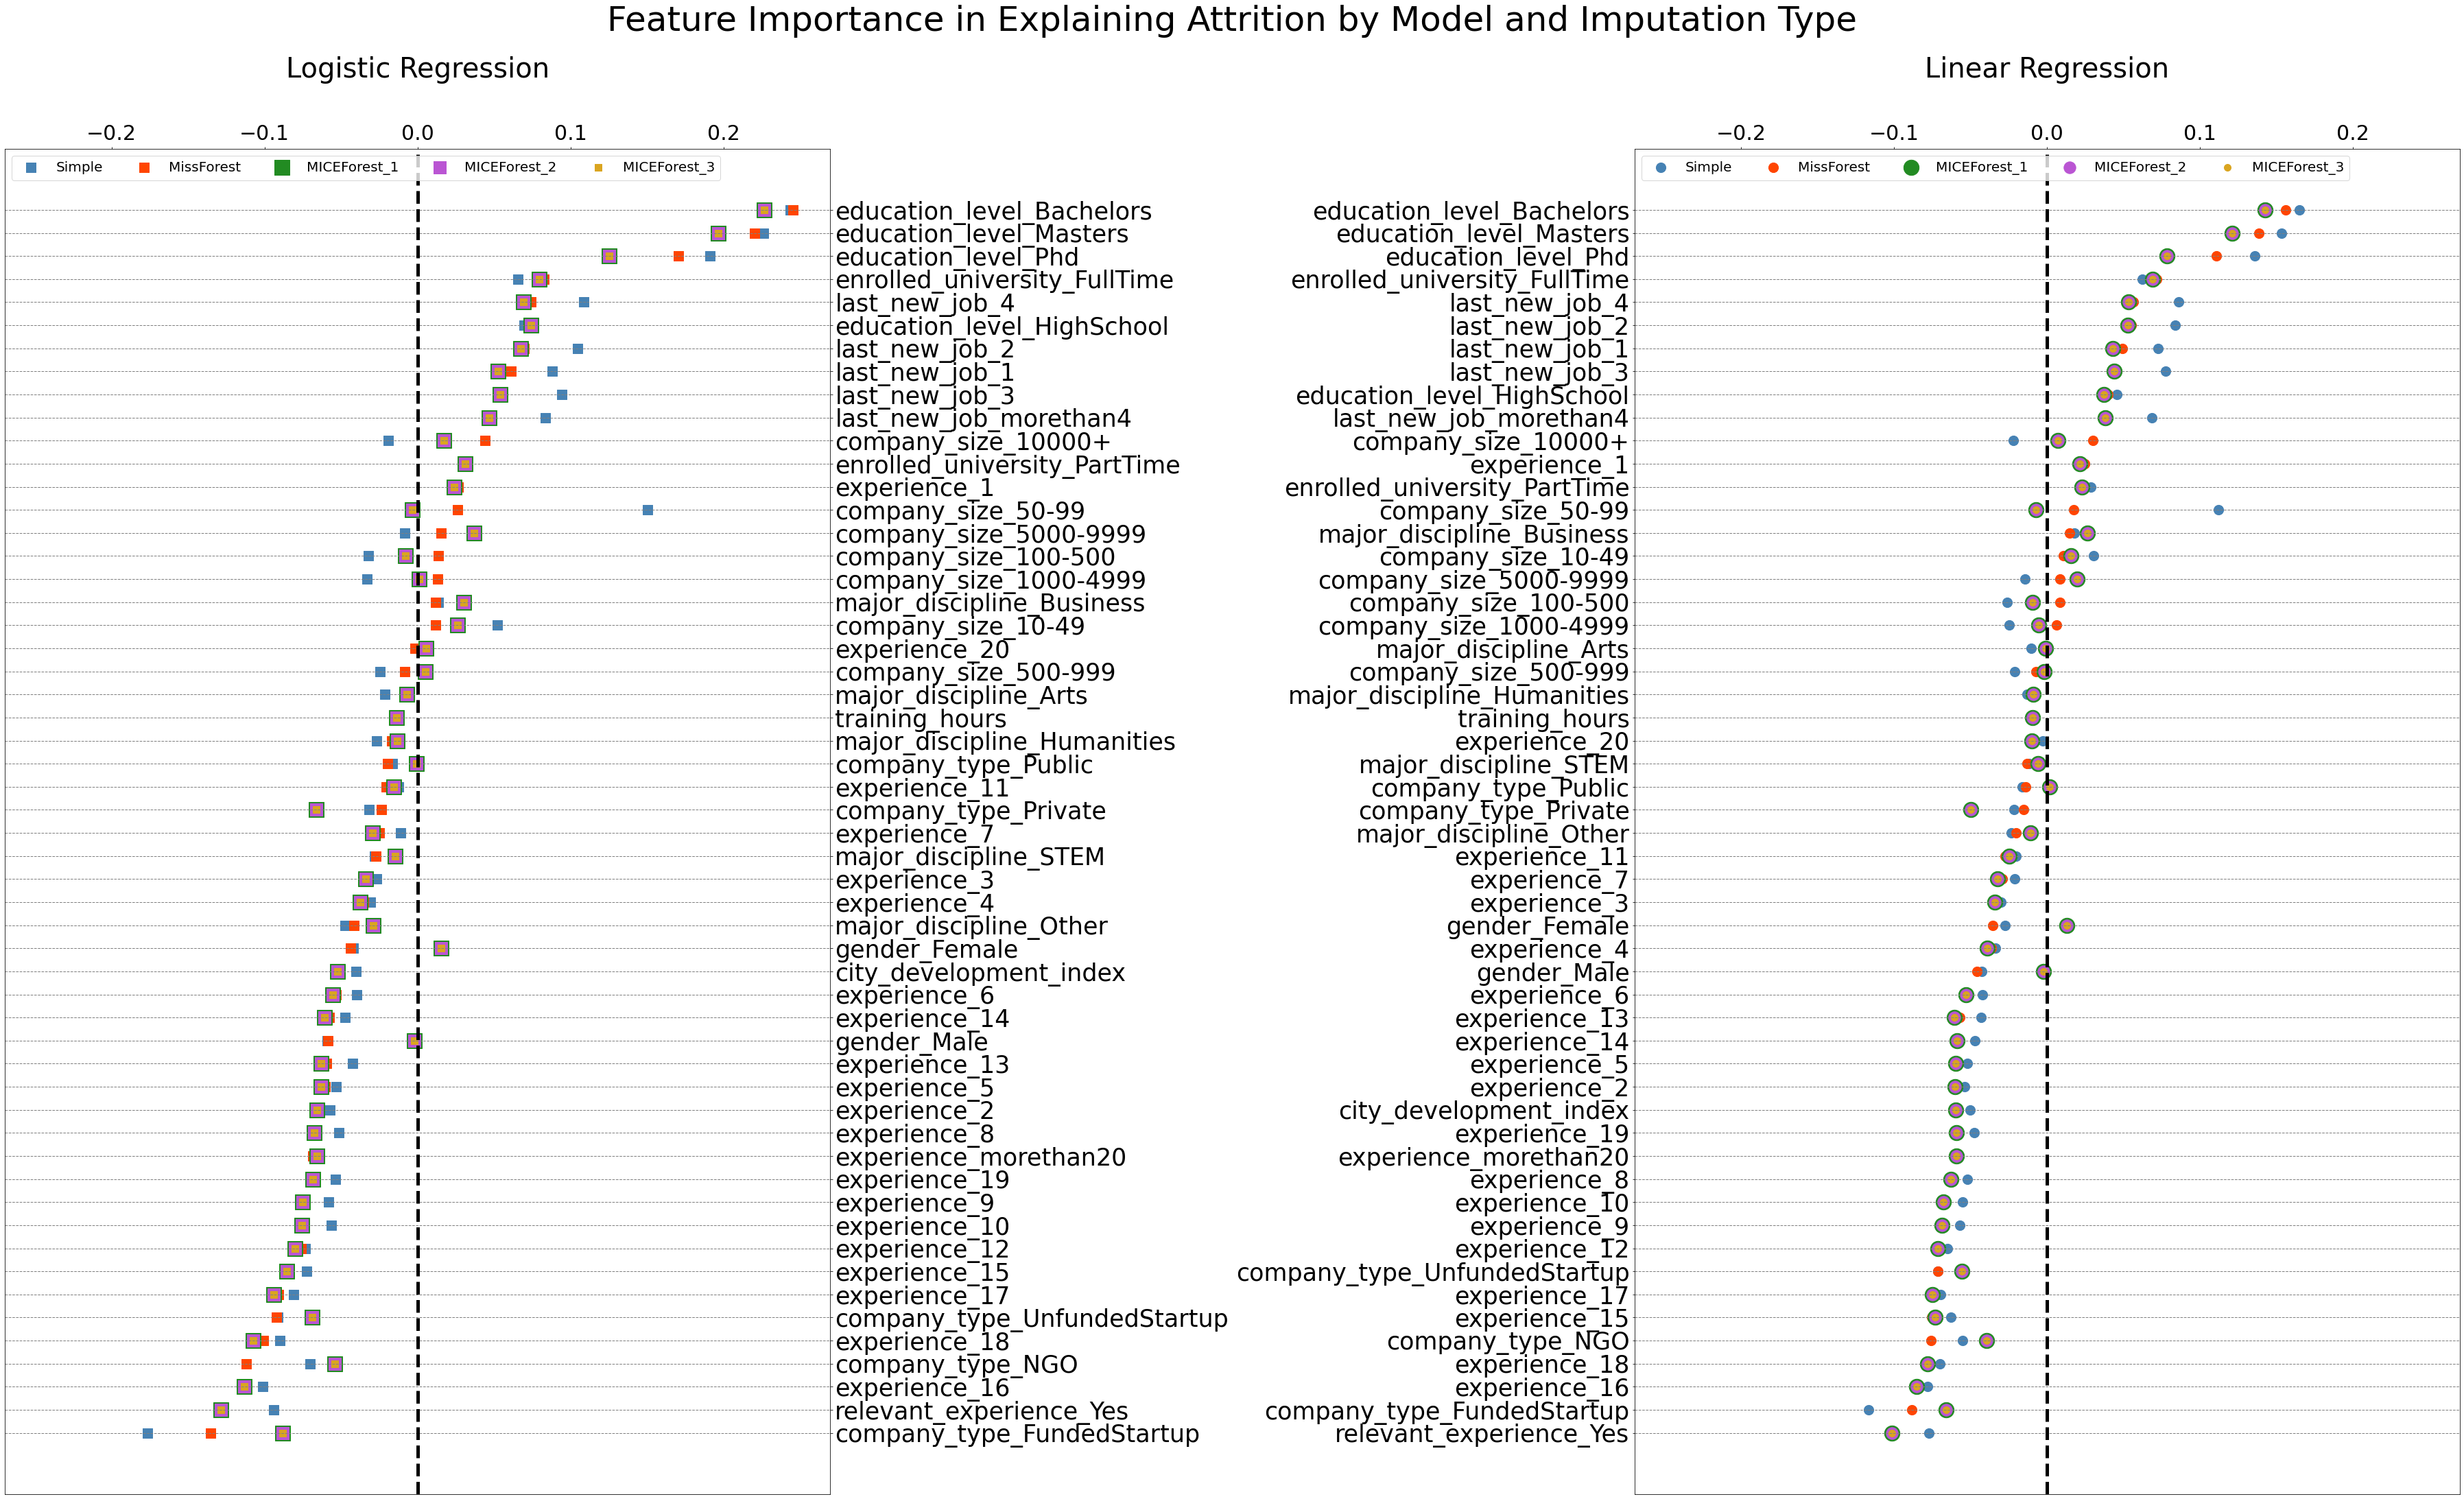

In [38]:
# Now plot the graphs

model_Effects = model_Effects.iloc[(model_Effects['Logistic_MissForest_Data_1']).argsort()]
maxlimit = max(max([max(model_Effects['Logistic_'+name].abs()) for name,_ in imputed_all]), 
               max([max(model_Effects['Linear_'+name].abs()) for name,_ in imputed_all]))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (50, 30))
#plt.subplot(1,2,1)
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_Simple_Data_1'], marker = 's', s = 200, color = 'steelblue', label = 'Simple')
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_MissForest_Data_1'], marker = 's', s = 200, color = 'orangered', label = 'MissForest')
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_MICEForest_Data_1'], marker = 's', s = 500, color = 'forestgreen', label = 'MICEForest_1')
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_MICEForest_Data_1'], marker = 's', s = 300, color = 'mediumorchid', label = 'MICEForest_2')
ax1.scatter(y = model_Effects['Feature'], x = model_Effects['Logistic_MICEForest_Data_1'], marker = 's', s = 100, color = 'goldenrod', label = 'MICEForest_3')
ax1.axvline(x = 0., linestyle = '--', color = 'black', linewidth = 5)
ax1.set_yticklabels(model_Effects['Feature'], fontsize = 35)
ax1.tick_params(axis = 'x', labelsize = 30)
ax1.set_ylabel('')
ax1.yaxis.tick_right()
ax1.xaxis.tick_top()
ax1.grid(which = 'major', axis = 'y', color = 'gray', linewidth = 1, linestyle = '--')
ax1.set_title('Logistic Regression', fontsize = 40, y = 1.05)
ax1.set_xlim(-maxlimit-maxlimit/10., maxlimit+maxlimit/10.)
ax1.legend(loc = 'upper left', ncol = 5, prop={'size': 20});


model_Effects = model_Effects.iloc[model_Effects['Linear_MissForest_Data_1'].argsort()]
#plt.subplot(1,2,2)
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_Simple_Data_1'], marker = 'o', s = 200, color = 'steelblue', label = 'Simple')
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_MissForest_Data_1'], marker = 'o', s = 200, color = 'orangered', label = 'MissForest')
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_MICEForest_Data_1'], marker = 'o', s = 500, color = 'forestgreen', label = 'MICEForest_1')
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_MICEForest_Data_1'], marker = 'o', s = 300, color = 'mediumorchid', label = 'MICEForest_2')
ax2.scatter(y = model_Effects['Feature'], x = model_Effects['Linear_MICEForest_Data_1'], marker = 'o', s = 100, color = 'goldenrod', label = 'MICEForest_3')
ax2.axvline(x = 0., linestyle = '--', color = 'black', linewidth = 5)
ax2.set_yticklabels(model_Effects['Feature'], fontsize = 35)
ax2.tick_params(axis = 'x', labelsize = 30)
ax2.set_ylabel('')
ax2.xaxis.tick_top()
ax2.grid(which = 'major', axis = 'y', color = 'gray', linewidth = 1, linestyle = '--')
ax2.set_title('Linear Regression', fontsize = 40, y = 1.05)
ax2.set_xlim(-maxlimit-maxlimit/10., maxlimit+maxlimit/10.)
ax2.legend(loc = 'upper left', ncol = 5, prop={'size': 20});

plt.suptitle('Feature Importance in Explaining Attrition by Model and Imputation Type', fontsize = 50, y = 1.01)
plt.tight_layout(); 
plt.savefig(os.path.join(sourcepath, 'reports', 'figures', 'FeatureEffectsOnExistDecision.png'), bbox_inches = 'tight')

##### Takeaway:

The main takeaways from the two graphs above are the following:
1. Coefficient estimates for the same feature and for the same model, are similar in magnitude and sign across imputed datasets. 
2. Coefficient estimates for the same feature and for same imputed dataset, are similar in magnitude and sign across models. 
3. Conditional on other features, having higher education is more likely to induce exits. 
    - This is very likely because of the fact that data scientists with higher levels of education have a lot of outside options, which are potentially better than those with lower levels of education. Therefore, conditional on everything else, they are more likely to exit.  
4. Conditional on other features, being enrolled full time in university is also more likely to induce exits. 
    - This can be explained by the fact those who are enrolled full time in university are going back to finish their education before they join a position. Hence they are more likely to leave.   
5. Conditional on other features, having more years of experience is less likely to induce exits. 
    - On the face of it, this might be counter intuitive since people with more years of experience are more likely to have better outside options and should therefore be more likely to leave. However, a more likely explanation here is that these individuals are looking to change their career paths by moving into data science positions at older ages. Therefore, it is more likely that they attended the training in order to make that career shift. So they are much less likely to leave, conditional on everything else being the same.    
6. Conditional on other features, having relevant experience is also less likely to induce exits. 
    - This has a very similar explanation to the point above. These are individuals with relevant experience and have selected into the training program, precisely because they want to be employed by this firm. Therefore, they are much less likely to leave. 
 


### (C) Predicting Exit Decision Using Classifier Algorithms

Next, I use different classifier algorithms to predict exit decisions. Since I want to compare different algorithms' performance in prediction, I need to set aside the same test set for each imputed dataset. Also, if I look at the proportion of exits in the full dataset, I find that only about 25% of people leave. Therefore, if I randomly split the data into train and test sets, each of these two sets would have 25% of exits. Therfore, I also conduct two other sampling analyses - OverSampling where the exit observations are oversampled, and UnderSampling where the Stayer observations are undersampled.  

Consider the training program director's optimal problem. They are trying to pin down a sample of candidates who will be offered training in a way that they can maximize the conversion into full-time positions after training completion. Since training each participant is costly, regardless of whether they leave or stay, the director selects the candidates with the expectation that all of them would stay. The classifier should then help us find how many of those accepted into the program would actually stay. In other words, we are trying to maximize the precision of the classifier.   

Here I use the following classifier algorithms:

1. Simple Logistic Regression with no regularization (Logit_Simple)
2. Logistic Regression with hyperparameter tuning (Logit_GridSearchCV)
3. Logistic Regression with Recursive feature elimination with cross validation (Logit_RFECV)
4. Random Forest Classifier with default hyperparameters and bagging (RandomForest)
5. Gradient Boosting Classifier with default hyperparameters (XGBoost)
6. Simple Neural Network with one hidden layer (128 neurons), sigmoid activations in both hidden and output layers. 

I first create 3 training sets for each of the 5 imputed datasets (Simple Imputation, MissForest Imputation, and 3 MICEForest Imputations). These 3 training sets are as follows: unbalanced training set, oversampled training set, and undersampled training set. For each imputed dataset, I set aside the same test set across the three train sets. Then I separately train each of the 6 classifier models above on each of the 15 (= 5X3) datasets. Then I use the appropriate test set to compute 5 performance metrics - accuracy, precision, recall, f1 score and roc-auc score. 

Then I compare these metrics to find the best combination of classifier model, imputation method, and sampling method. 

In [75]:
dataholder = {}
datanames = []
samplingtypes = ['Unbalanced','OverSampling','UnderSampling']
for i in np.arange(len(imputed_all_scaled)):
    datanames.append(imputed_all_scaled[i][0])
    dataholder[imputed_all_scaled[i][0]] = {}
    dataholder[imputed_all_scaled[i][0]]['Train'] = {}   
    
print(datanames)
print(dataholder)

['Simple_Data_1', 'MissForest_Data_1', 'MICEForest_Data_1', 'MICEForest_Data_2', 'MICEForest_Data_3']
{'Simple_Data_1': {'Train': {}}, 'MissForest_Data_1': {'Train': {}}, 'MICEForest_Data_1': {'Train': {}}, 'MICEForest_Data_2': {'Train': {}}, 'MICEForest_Data_3': {'Train': {}}}


In [76]:
## First we create the unbalanced datasets and insert them into the correct dictionary along with the target

test_size = 0.2
seed = 1007

# Iterate over the imputed datasets
for counter, dataname in enumerate(datanames):
    
    print('\nData Name:', dataname)
    
    # Dummify the data
    newframe = pd.get_dummies(imputed_all_scaled[counter][1], drop_first = False)
    
    # Split the data if required or use previously split indices if available
    # Note that these are unbalanced datasets
    if(counter == 0):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(newframe, Data['target'], test_size = test_size, random_state = seed)
        trainindex = Xtrain.index.to_list()
        testindex = Xtest.index.to_list()
    else:    
        Xtrain = newframe.iloc[trainindex, :]
        Xtest = newframe.iloc[testindex, :]
        Ytrain = Data['target'].iloc[trainindex]
        Ytest = Data['target'].iloc[testindex]      
    
    print('Unbalanced Train Shapes:', Xtrain.shape, Ytrain.shape)
    print('Test Shapes:', Xtest.shape, Ytest.shape)
    
    # Now push the unbalanced train and test set into the right dictionary
    dataholder[dataname]['Train']['Unbalanced'] = (Xtrain, Ytrain)
    dataholder[dataname]['Test'] = (Xtest, Ytest)
    
    # Now create an underbalanced and overbalanced train sets 
    XtrainNew, YtrainNew = RandomOverSampler().fit_resample(Xtrain, Ytrain)
    dataholder[dataname]['Train']['OverSampling'] = (XtrainNew, YtrainNew)   
    print('OverSampled Train Shapes:', XtrainNew.shape, YtrainNew.shape)
    
    XtrainNew, YtrainNew = RandomUnderSampler().fit_resample(Xtrain, Ytrain)
    dataholder[dataname]['Train']['UnderSampling'] = (XtrainNew, YtrainNew)
    print('UnderSampled Train Shapes:', XtrainNew.shape, YtrainNew.shape)   


Data Name: Simple_Data_1
Unbalanced Train Shapes: (15326, 186) (15326,)
Test Shapes: (3832, 186) (3832,)
OverSampled Train Shapes: (22984, 186) (22984,)
UnderSampled Train Shapes: (7668, 186) (7668,)

Data Name: MissForest_Data_1
Unbalanced Train Shapes: (15326, 186) (15326,)
Test Shapes: (3832, 186) (3832,)
OverSampled Train Shapes: (22984, 186) (22984,)
UnderSampled Train Shapes: (7668, 186) (7668,)

Data Name: MICEForest_Data_1
Unbalanced Train Shapes: (15326, 186) (15326,)
Test Shapes: (3832, 186) (3832,)
OverSampled Train Shapes: (22984, 186) (22984,)
UnderSampled Train Shapes: (7668, 186) (7668,)

Data Name: MICEForest_Data_2
Unbalanced Train Shapes: (15326, 186) (15326,)
Test Shapes: (3832, 186) (3832,)
OverSampled Train Shapes: (22984, 186) (22984,)
UnderSampled Train Shapes: (7668, 186) (7668,)

Data Name: MICEForest_Data_3
Unbalanced Train Shapes: (15326, 186) (15326,)
Test Shapes: (3832, 186) (3832,)
OverSampled Train Shapes: (22984, 186) (22984,)
UnderSampled Train Shapes:

In [77]:
## Logistic Regression with no penalty and default hyperparameters

# Logistic (no regularization), # Logistic with GridSearchCV, # Logistic with feature selection
# Random Forest (default), # Random Forest with GridSearchCV, # XGBoost (default), # XGBoost with GridSearchCV, # NN

def Logit_Simple(traindata, testdata):
    
    trainX = traindata[0]
    trainY = traindata[1]
    testX = testdata[0]
    testY = testdata[1]
    
    # Define the model first
    logreg = LogisticRegression(penalty = 'none', random_state = seed)
    model = logreg.fit(trainX, trainY)
    
    # Now predict the test labels and the test probabilities
    Ytestpred = model.predict(testX)
    #Ytestprob = model.predict_proba(testX)[:,1]
    
    accuracy = accuracy_score(testY, Ytestpred)
    precision = precision_score(testY, Ytestpred)
    recall = recall_score(testY, Ytestpred)
    f1score = f1_score(testY, Ytestpred)
    rocauc = roc_auc_score(testY, Ytestpred)
    #rocauccurve = roc_curve(testY, Ytestprob)
    
    return accuracy, precision, recall, f1score, rocauc, model

In [78]:
## Logistic Regression with Grid Search over Hyperparameters

def Logit_GridSearchCV(traindata, testdata, paramgrid):
    
    trainX = traindata[0]
    trainY = traindata[1]
    testX = testdata[0]
    testY = testdata[1]

    logtuned = GridSearchCV(LogisticRegression(random_state = seed), paramgrid, 
                            verbose = 0, scoring = 'precision', cv = 3)
    model = logtuned.fit(trainX, trainY)
    
    # Now predict the test labels and the test probabilities
    Ytestpred = model.predict(testX)
    #Ytestprob = model.predict_proba(testX)[:,1]
    
    accuracy = accuracy_score(testY, Ytestpred)
    precision = precision_score(testY, Ytestpred)
    recall = recall_score(testY, Ytestpred)
    f1score = f1_score(testY, Ytestpred)
    rocauc = roc_auc_score(testY, Ytestpred)
    #rocauccurve = roc_curve(testY, Ytestprob)
    
    return accuracy, precision, recall, f1score, rocauc, model

In [79]:
## Logistic Regression with Recursive Feature Elimination with Cross Validation

def Logit_RFECV(traindata, testdata):
    
    trainX = traindata[0]
    trainY = traindata[1]
    testX = testdata[0]
    testY = testdata[1]

    logitRFECV = RFECV(LogisticRegression(), step = 1, min_features_to_select = 1, cv = 3, scoring = 'precision', verbose = 0)
    model = logitRFECV.fit(trainX, trainY)
    
    # Now predict the test labels and the test probabilities
    Ytestpred = model.predict(testX)
    #Ytestprob = model.predict_proba(testX)[:,1]
    
    accuracy = accuracy_score(testY, Ytestpred)
    precision = precision_score(testY, Ytestpred)
    recall = recall_score(testY, Ytestpred)
    f1score = f1_score(testY, Ytestpred)
    rocauc = roc_auc_score(testY, Ytestpred)
    #rocauccurve = roc_curve(testY, Ytestprob)
    
    return accuracy, precision, recall, f1score, rocauc, model

In [80]:
## Random Forest with Default Hyperparameters

def RandomForest_Simple(traindata, testdata):
    
    trainX = traindata[0]
    trainY = traindata[1]
    testX = testdata[0]
    testY = testdata[1]
    
    # Define the model first
    rf = RandomForestClassifier(bootstrap = True, oob_score = True, verbose = 0, random_state = seed)
    model = rf.fit(trainX, trainY)
    
    # Now predict the test labels and the test probabilities
    Ytestpred = model.predict(testX)
    #Ytestprob = model.predict_proba(testX)[:,1]
    
    accuracy = accuracy_score(testY, Ytestpred)
    precision = precision_score(testY, Ytestpred)
    recall = recall_score(testY, Ytestpred)
    f1score = f1_score(testY, Ytestpred)
    rocauc = roc_auc_score(testY, Ytestpred)
    #rocauccurve = roc_curve(testY, Ytestprob)
    
    return accuracy, precision, recall, f1score, rocauc, model

In [81]:
## XgBoost Classifier

def XGBoost_Simple(traindata, testdata):
    
    trainX = traindata[0]
    trainY = traindata[1]
    testX = testdata[0]
    testY = testdata[1]
    
    # Define the model first
    xgb = XGBClassifier(verbosity = 0, random_state = seed)
    model = xgb.fit(trainX, trainY)
    
    # Now predict the test labels and the test probabilities
    Ytestpred = model.predict(testX)
    #Ytestprob = model.predict_proba(testX)[:,1]
    
    accuracy = accuracy_score(testY, Ytestpred)
    precision = precision_score(testY, Ytestpred)
    recall = recall_score(testY, Ytestpred)
    f1score = f1_score(testY, Ytestpred)
    rocauc = roc_auc_score(testY, Ytestpred)
    #rocauccurve = roc_curve(testY, Ytestprob)
    
    return accuracy, precision, recall, f1score, rocauc, model

In [126]:
## Neural Network 

def NeuralNet(traindata, testdata):
    
    trainX = traindata[0]
    trainY = traindata[1]
    testX = testdata[0]
    testY = testdata[1]
    
    # Now define the model
    NNC = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_shape = (trainX.shape[1],), units = 128, activation = tf.nn.sigmoid), 
        #tf.keras.layers.Dense(units = 512, activation = tf.nn.sigmoid),
        #tf.keras.layers.Dense(units = 1024, activation = tf.nn.sigmoid),
        tf.keras.layers.Dense(units = 1, activation = tf.nn.sigmoid)
    ])
    
    # Compile the model
    NNC.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    
    accuracy_threshold = 0.93
    num_epochs = 100

    class myCallBack(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs = {}):
            if(logs.get('acc') > accuracy_threshold): 
                self.model.stop_training = True
    callbacks = myCallBack()            

    # Train the model            
    history = NNC.fit(trainX, trainY, epochs = num_epochs, callbacks = [callbacks], verbose = 0)
    
    # Now predict the test labels and the test probabilities
    Ytestpred = NNC.predict_classes(testX, verbose = 0)[:,0]
    #Ytestprob = model.predict(testX, verbose = 0)[:,0]
    
    accuracy = accuracy_score(testY, Ytestpred)
    precision = precision_score(testY, Ytestpred)
    recall = recall_score(testY, Ytestpred)
    f1score = f1_score(testY, Ytestpred)
    rocauc = roc_auc_score(testY, Ytestpred)
    #rocauccurve = roc_curve(testY, Ytestprob)
    
    return accuracy, precision, recall, f1score, rocauc, NNC 

In [127]:
# Defining the parameters to be used for grid search 

logitparamgrid = {'penalty':['l1','l2'], 
                  'C':np.logspace(-3, 3, 20), 
                  'fit_intercept':[True, False]}

In [128]:
# Now implement the classifier algorithms
outputholder = {'Data':[], 'Sampling':[], 'Model':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1Score':[], 'ROCScore':[]}

# Iterate over the datasets:
for dataname in datanames:  
    # Iterate over the sampling types
    for samplingtype in samplingtypes:
        
        # Simple Logistic Regression
        starttime = time.time()
        accuracy, precision, recall, f1score, rocauc, model = Logit_Simple(dataholder[dataname]['Train'][samplingtype], 
                                                                           dataholder[dataname]['Test'])
        outputholder['Data'].append(dataname)
        outputholder['Sampling'].append(samplingtype)
        outputholder['Model'].append('Logit_Simple')
        outputholder['Accuracy'].append(accuracy)
        outputholder['Precision'].append(precision)
        outputholder['Recall'].append(recall)
        outputholder['F1Score'].append(f1score)
        outputholder['ROCScore'].append(rocauc)
        filename = dataname+'_('+samplingtype+')_[Logit_Simple].sav'       
        pickle.dump(model, open(os.path.join(sourcepath, 'models', filename), 'wb'))
        print('Training - '+filename, 'Time taken: {:.4f} seconds.'.format(time.time()-starttime))
        
        # Logistic Regression with optimized hyperparameters
        starttime = time.time()
        accuracy, precision, recall, f1score, rocauc, model = Logit_GridSearchCV(dataholder[dataname]['Train'][samplingtype], 
                                                                           dataholder[dataname]['Test'], logitparamgrid)
        outputholder['Data'].append(dataname)
        outputholder['Sampling'].append(samplingtype)
        outputholder['Model'].append('Logit_GridSearchCV')
        outputholder['Accuracy'].append(accuracy)
        outputholder['Precision'].append(precision)
        outputholder['Recall'].append(recall)
        outputholder['F1Score'].append(f1score)
        outputholder['ROCScore'].append(rocauc)
        filename = dataname+'_('+samplingtype+')_[Logit_GridSearchCV].sav'       
        pickle.dump(model, open(os.path.join(sourcepath, 'models', filename), 'wb'))
        print('Training - '+filename, 'Time taken: {:.4f} seconds.'.format(time.time()-starttime))
        
        # Logistic Regression with feature elimination
        starttime = time.time()
        accuracy, precision, recall, f1score, rocauc, model = Logit_RFECV(dataholder[dataname]['Train'][samplingtype], 
                                                                           dataholder[dataname]['Test'])
        outputholder['Data'].append(dataname)
        outputholder['Sampling'].append(samplingtype)
        outputholder['Model'].append('Logit_RFECV')
        outputholder['Accuracy'].append(accuracy)
        outputholder['Precision'].append(precision)
        outputholder['Recall'].append(recall)
        outputholder['F1Score'].append(f1score)
        outputholder['ROCScore'].append(rocauc)
        filename = dataname+'_('+samplingtype+')_[Logit_RFECV].sav'       
        pickle.dump(model, open(os.path.join(sourcepath, 'models', filename), 'wb'))
        print('Training - '+filename, 'Time taken: {:.4f} seconds.'.format(time.time()-starttime))
        
        # Random Forest Classifier
        starttime = time.time()
        accuracy, precision, recall, f1score, rocauc, model = RandomForest_Simple(dataholder[dataname]['Train'][samplingtype], 
                                                                           dataholder[dataname]['Test'])
        outputholder['Data'].append(dataname)
        outputholder['Sampling'].append(samplingtype)
        outputholder['Model'].append('RandomForest')
        outputholder['Accuracy'].append(accuracy)
        outputholder['Precision'].append(precision)
        outputholder['Recall'].append(recall)
        outputholder['F1Score'].append(f1score)
        outputholder['ROCScore'].append(rocauc)
        filename = dataname+'_('+samplingtype+')_[RandomForest].sav'       
        pickle.dump(model, open(os.path.join(sourcepath, 'models', filename), 'wb'))
        print('Training - '+filename, 'Time taken: {:.4f} seconds.'.format(time.time()-starttime))
        
        # XGBoost Classifier
        starttime = time.time()
        accuracy, precision, recall, f1score, rocauc, model = XGBoost_Simple(dataholder[dataname]['Train'][samplingtype], 
                                                                           dataholder[dataname]['Test'])
        outputholder['Data'].append(dataname)
        outputholder['Sampling'].append(samplingtype)
        outputholder['Model'].append('XGBoost')
        outputholder['Accuracy'].append(accuracy)
        outputholder['Precision'].append(precision)
        outputholder['Recall'].append(recall)
        outputholder['F1Score'].append(f1score)
        outputholder['ROCScore'].append(rocauc)
        filename = dataname+'_('+samplingtype+')_[XGBoost].sav'       
        pickle.dump(model, open(os.path.join(sourcepath, 'models', filename), 'wb'))
        print('Training - '+filename, 'Time taken: {:.4f} seconds.'.format(time.time()-starttime)) 
        
        # Neural Network Classifier
        starttime = time.time()
        accuracy, precision, recall, f1score, rocauc, model = NeuralNet(dataholder[dataname]['Train'][samplingtype], 
                                                                           dataholder[dataname]['Test'])
        outputholder['Data'].append(dataname)
        outputholder['Sampling'].append(samplingtype)
        outputholder['Model'].append('NeuralNet')
        outputholder['Accuracy'].append(accuracy)
        outputholder['Precision'].append(precision)
        outputholder['Recall'].append(recall)
        outputholder['F1Score'].append(f1score)
        outputholder['ROCScore'].append(rocauc)
        filename = dataname+'_('+samplingtype+')_[NeuralNet].sav'       
        model.save(os.path.join(sourcepath, 'models', filename))
        print('Training - '+filename, 'Time taken: {:.4f} seconds.'.format(time.time()-starttime))         


Training - Simple_Data_1_(Unbalanced)_[Logit_Simple].sav Time taken: 0.8916 seconds.
Training - Simple_Data_1_(Unbalanced)_[Logit_GridSearchCV].sav Time taken: 71.0015 seconds.
Training - Simple_Data_1_(Unbalanced)_[Logit_RFECV].sav Time taken: 239.3180 seconds.
Training - Simple_Data_1_(Unbalanced)_[RandomForest].sav Time taken: 6.6263 seconds.
Training - Simple_Data_1_(Unbalanced)_[XGBoost].sav Time taken: 6.7348 seconds.
Training - Simple_Data_1_(Unbalanced)_[NeuralNet].sav Time taken: 94.9546 seconds.
Training - Simple_Data_1_(OverSampling)_[Logit_Simple].sav Time taken: 1.3209 seconds.
Training - Simple_Data_1_(OverSampling)_[Logit_GridSearchCV].sav Time taken: 92.2245 seconds.
Training - Simple_Data_1_(OverSampling)_[Logit_RFECV].sav Time taken: 412.8183 seconds.
Training - Simple_Data_1_(OverSampling)_[RandomForest].sav Time taken: 9.5945 seconds.
Training - Simple_Data_1_(OverSampling)_[XGBoost].sav Time taken: 8.4951 seconds.
Training - Simple_Data_1_(OverSampling)_[NeuralNet]

In [129]:
## Check that each key has the same number of elements

for (key, value) in outputholder.items():
    assert len(outputholder[key])==len(datanames)*len(samplingtypes)*6

#### Post-Processing of Prediction Performance Metrics

Recall that I had 3 imputed datasets from the MICE Forest imputation method, besides the Simple imputed dataset and the MissForest imputed dataset. I also have 5 prediction performance metrics for each combination of classifier model, imputed dataset, and sampling method. Therefore, for each combination of classifier model and sampling method, I average the relevant performance metric across the 3 MICE Forest imputed datasets. 

This leaves me with values of 5 performance metrics for each combination of 3 imputed datasets, 3 sampling methods, and 6 classifier models.   

In [131]:
# Now convert this dictionary of output metrics to a dataframe
predictmetrics = pd.DataFrame(outputholder)

# Save the dataframe for safety
predictmetrics.to_csv(os.path.join(sourcepath, 'reports', 'PredictionMetrics.csv'), header = True, index = False) 

#oldmetrics = predictmetrics.copy(deep = True)

# Change the names of the datasets in the Data column
predictmetrics['Data'] = predictmetrics['Data'].apply(lambda x: 'Simple' if 'Simple' in x else x)
predictmetrics['Data'] = predictmetrics['Data'].apply(lambda x: 'MissForest' if 'MissForest' in x else x)
predictmetrics['Data'] = predictmetrics['Data'].apply(lambda x: 'MICEForest' if 'MICEForest' in x else x)

# Now average within Data, Sampling, Model
newmetrics = predictmetrics.groupby(['Data','Sampling','Model'])[['Accuracy','Precision','Recall','F1Score','ROCScore']].mean().reset_index()

# Now collate the Data and Sampling type into one columns
newmetrics['DataSampling'] = newmetrics[['Data', 'Sampling']].agg('_'.join, axis=1) 

#### Plotting Prediction Metrics

Now I need to make sense of our predictions. In particular, I need to find out the model, imputation type, and sampling type which gives us 'better' prediction results. I do this in two ways:

First, for each prediction metric (accuracy, precision, recall, f1 score, and roc-auc score) I show a heatmap with one axis depicting the 6 different models used, and the other axis depicting the 18 combinations of imputation and sampling methods. Reading these heatmaps will give me an idea about the best model to choose from, depending on which prediction metric I would like to maximize as our objective. 

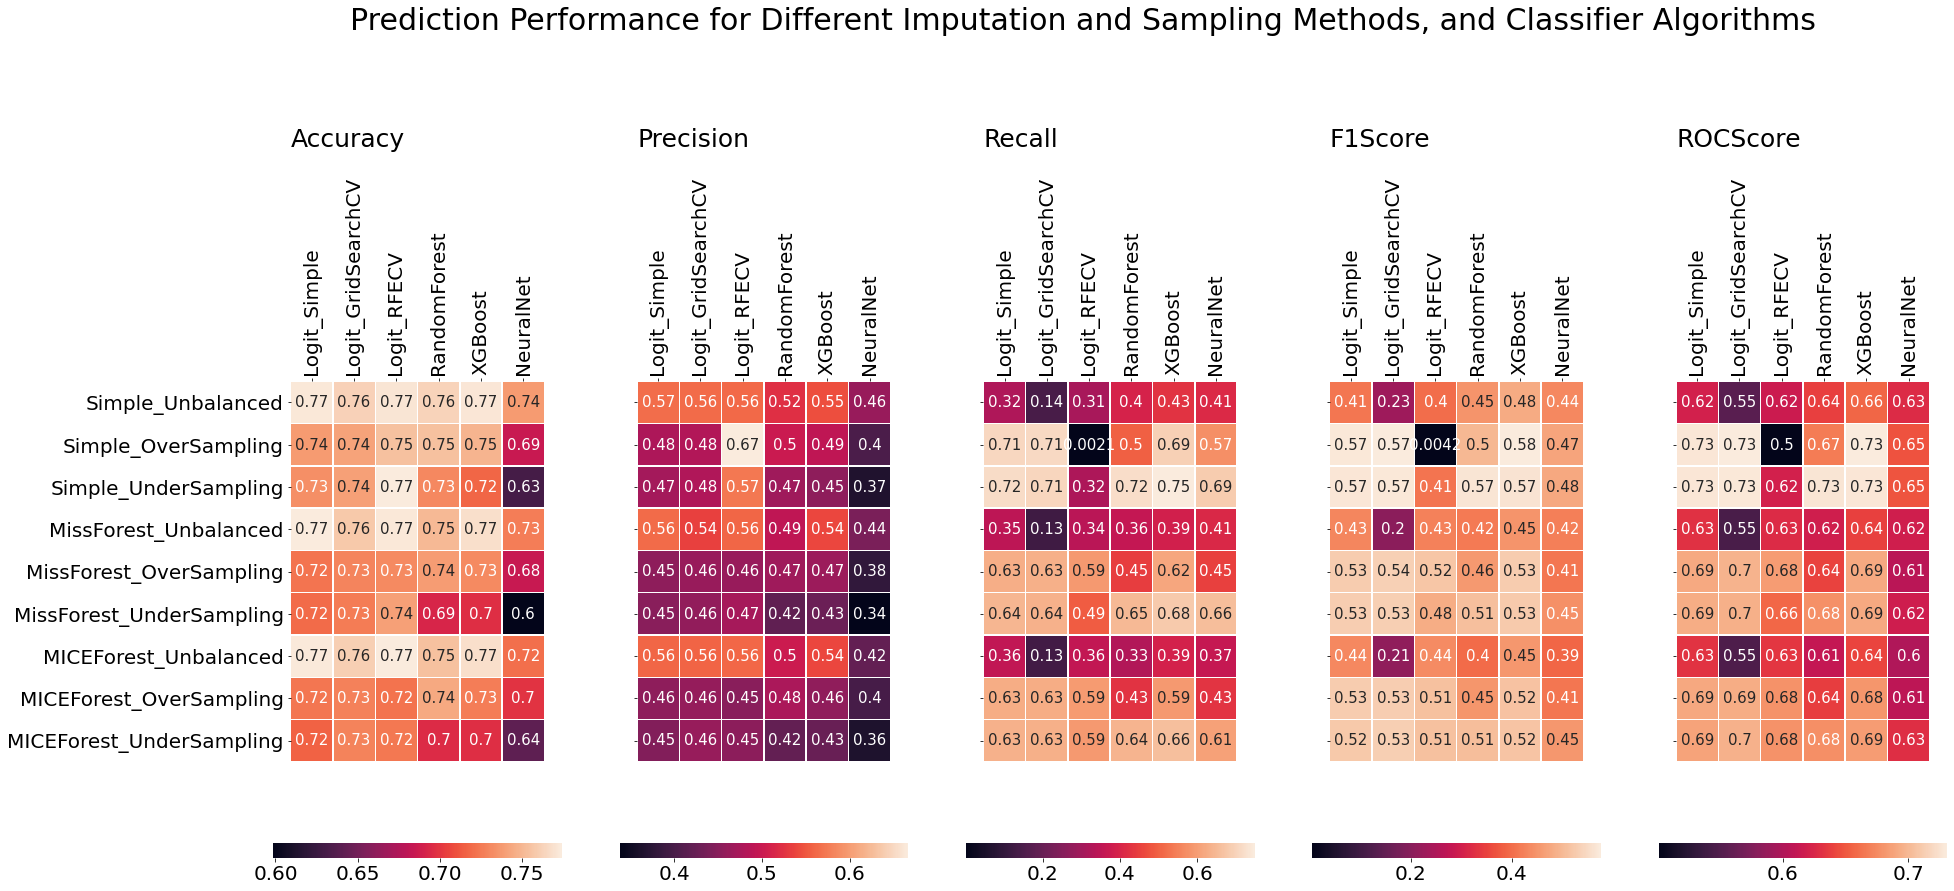

In [132]:
metricslist = ['Accuracy', 'Precision', 'Recall', 'F1Score', 'ROCScore']
cmap = sns.diverging_palette(230, 20, as_cmap = True)

fig, ax = plt.subplots(1, len(metricslist), figsize = (30, 10), sharey = True)

# Now iterate over the list of metrics
for counter, metric in enumerate(metricslist):
    
    # First retain the correct part of the frame
    tempframe = newmetrics[[metric, 'Model','DataSampling']]
    # Now convert the dataframe from a long to wide shape
    tempframe = tempframe.pivot_table(index = 'DataSampling', columns = 'Model', values = metric) 
    
    # Now order the columns in a given way
    tempframe = tempframe[['Logit_Simple', 'Logit_GridSearchCV', 'Logit_RFECV', 'RandomForest', 'XGBoost', 'NeuralNet']]
    # Now change the rows in a certain way
    tempframe = tempframe.reindex(['Simple_Unbalanced','Simple_OverSampling','Simple_UnderSampling', 
                                   'MissForest_Unbalanced','MissForest_OverSampling','MissForest_UnderSampling', 
                                   'MICEForest_Unbalanced','MICEForest_OverSampling','MICEForest_UnderSampling'])
    
    #print(tempframe)
    
    # Now plot the heatmap
    g = sns.heatmap(tempframe, vmax = max(tempframe.max()), vmin = min(tempframe.min()), annot = True, 
                    square = True, linewidth = 0.5, ax = ax[counter], 
                    cbar_kws={"shrink": 1.,"use_gridspec":False,"location":"bottom"}, annot_kws={"fontsize":15})
    cbar = ax[counter].collections[0].colorbar 
    cbar.ax.tick_params(labelsize=20) 
    ax[counter].set_title(metric, fontsize = 25, loc = 'left', y = 1.6)
    ax[counter].xaxis.tick_top()
    ax[counter].set_xticklabels(tempframe.columns, rotation = 90, fontsize = 20)
    ax[counter].set_yticklabels(tempframe.index, rotation = 360, fontsize = 20)
    ax[counter].set_xlabel('')
    ax[counter].set_ylabel('')
    
plt.suptitle('Prediction Performance for Different Imputation and Sampling Methods, and Classifier Algorithms', 
            fontsize = 30, y = 1.4);   
plt.savefig(os.path.join(sourcepath, 'reports', 'figures', 'PredictionMetricsComparison.png'), bbox_inches = 'tight')

##### Takeaway:

The heatmaps above show that if I want to focus on precision as our objective metric, then I should use simple imputation, with oversampling of exit observations, and a logistic regression classifier with recursive feature elimination. If however, I want to focus on ROC-AUC score as our prediction metric, then I should again use simple imputation method with either over or under sampling. However I should choose either Gradient Boosting classifier, or Logistic Classifier with grid search over hyperparameters. 

Overall, it is difficult to interpret the heatmaps above, because of the multitude of prediction metrics, sampling methods, imputation types, and classifier algorithms. Therefore, I need a more streamlined approach to find the best model. 

To do this, I focus only on two metrics - precision and roc-auc score and then show the different combinations of classifier algorithms, imputation methods, and sampling methods in a scatter plot. 

In [145]:
# Add a color column to newmetrics
 
Colour = pd.Series(['red','gold','lightcoral','blue','skyblue','black','forestgreen','olivedrab','fuchsia'])
Colour.index = ['Simple_Unbalanced','Simple_OverSampling','Simple_UnderSampling', 
                'MissForest_Unbalanced','MissForest_OverSampling','MissForest_UnderSampling', 
                'MICEForest_Unbalanced','MICEForest_OverSampling','MICEForest_UnderSampling'] 
newmetrics = newmetrics.set_index('DataSampling')
newmetrics['Colour'] = Colour
newmetrics.reset_index(inplace = True)


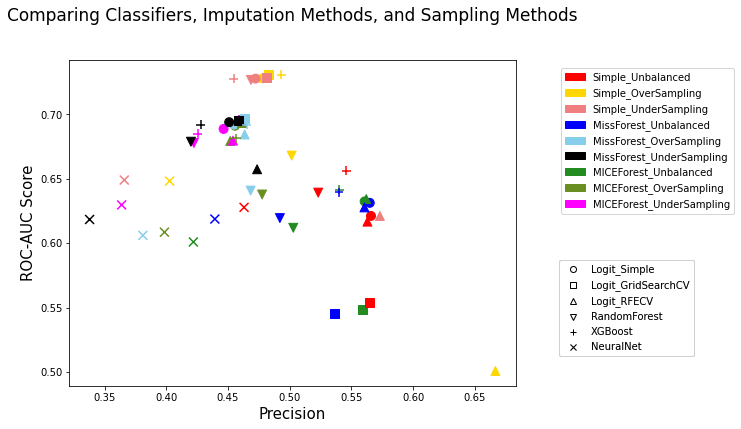

In [152]:
fig, ax = plt.subplots(figsize = (8, 6))    
    
markers = ['o', 's', '^', 'v', '+', 'x']
models = ['Logit_Simple', 'Logit_GridSearchCV', 'Logit_RFECV', 'RandomForest', 'XGBoost', 'NeuralNet']
for counter, model in enumerate(models):
    ax.scatter(newmetrics.loc[newmetrics['Model']==model,:]['Precision'], 
               newmetrics.loc[newmetrics['Model']==model,:]['ROCScore'], 
               c = newmetrics.loc[newmetrics['Model']==model,:]['Colour'], marker = markers[counter], s = 80)
    ax.set_xlabel('Precision', fontsize = 15)
    ax.set_ylabel('ROC-AUC Score', fontsize = 15)
    ax.set_title('Comparing Classifiers, Imputation Methods, and Sampling Methods', fontsize = 17, y = 1.1)
    
    rows = [mpatches.Patch(color=Colour[i]) for i in range(len(Colour))]
    labelrows = Colour.index.to_list()
    ax.legend(rows, labelrows, bbox_to_anchor = (1.5, 0.99, 0., 0.), ncol = 1)
    columns = [plt.plot([], [], markers[i], markerfacecolor='w', markeredgecolor='k')[0] for i in range(len(markers))]
    labelcolumns = models
    newlegend = Legend(ax, columns, labelcolumns, bbox_to_anchor = (1.41, 0.4, 0., 0.), ncol = 1) 
    ax.add_artist(newlegend)
plt.savefig(os.path.join(sourcepath, 'reports','figures','ComparisonModels.png'), bbox_inches = 'tight')    

##### Takeaway:

The plot above shows 9 combinations of imputed datasets and sampling types using 9 different colours, and 6 classifier models using different markers. The plot shows values of only test precision and test roc-auc scores. 

The plot shows that if we care about both test precision and test roc-auc score, then we should choose the XGBoost model and apply it to the simple imputed dataset and use an unbalanced training set. This point is marked in the plot above with a red cross. 

If however, we care only about test precision, then we should use a Logistic Regression model with recursive feature elimination, and apply it to a simply imputed dataset and oversampled training set. This is the yellow triangle at the bottom right of the plot above. 

Finally, if we care only about ROC-AUC, then we should apply an XGBoost model to a simply imputed dataset and oversample the training set. This is the yellow cross in the upper center of the plot above.  

In [153]:
# def CatBoost_Classifier(trainX, testX, trainY, testY):
    
#     # Recognize the categorical indices
#     catindices = [counter for counter, item in enumerate(trainX.columns.to_list()) if trainX[item].dtypes.name == 'category']  
    
#     # Now fit the default Logistic Regression
#     cbc = CatBoostClassifier(verbose = 0)
#     model = cbc.fit(trainX, trainY, cat_features=catindices) 
    
#     # Now predict the test labels
#     Ypred = model.predict(testX)
#     accuracy = accuracy_score(testY, Ypred)
#     precision = precision_score(testY, Ypred)
#     recall = recall_score(testY, Ypred)
#     f1score = f1_score(testY, Ypred)
#     rocauc = roc_auc_score(testY, Ypred)
    
#     return accuracy, precision, recall, f1score, rocauc

# def AdaBoost_Classifier(trainX, testX, trainY, testY):
    
#     # Now fit the default Logistic Regression
#     abc = AdaBoostClassifier()
#     model = abc.fit(trainX, trainY)
    
#     # Now predict the test labels
#     Ypred = model.predict(testX)
#     accuracy = accuracy_score(testY, Ypred)
#     precision = precision_score(testY, Ypred)
#     recall = recall_score(testY, Ypred)
#     f1score = f1_score(testY, Ypred)
#     rocauc = roc_auc_score(testY, Ypred)
    
#     return accuracy, precision, recall, f1score, rocauc
    